Imports

In [ ]:
from PIL import Image
from tqdm import tqdm
import json as js
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir as ld
from os import path, makedirs
from keras.models import Model #type: ignore
from keras.utils import to_categorical #type: ignore
from keras.losses import Huber #type: ignore
from collections import defaultdict
import random

2025-04-20 17:46:41.392838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 17:46:41.404464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-20 17:46:41.407965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 17:46:41.416974: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Involving paths

In [3]:
with open("config_CNN.json",'r') as file:
    paths = js.load(file)

Image Resizing

In [9]:
RESIZE_TO = (64, 64)

def adjust_bbox_for_resize(bbox, original_size, new_size):
    x, y, w, h = bbox
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    return [x * scale_x, y * scale_y, w * scale_x, h * scale_y]

def augment_and_save(image, bbox, filename, output_folder, bboxes_json, label, aug_id):
    aug_list = []
    
    # Flip horizontally
    flipped = image.transpose(Image.FLIP_LEFT_RIGHT)
    x, y, w, h = bbox
    x = 1.0 - x - w
    bbox_flip = [x, y, w, h]
    name_flip = filename.replace('.jpg', f'_flip{aug_id}.jpg')
    flipped.save(path.join(output_folder, name_flip))
    aug_list.append({"img_id": name_flip, "bbox": bbox_flip, "category_id": label})

    # Rotate 90 degrees
    rotated = image.transpose(Image.ROTATE_90)
    x, y, w, h = bbox
    bbox_rot = [y, 1.0 - x - w, h, w]
    name_rot = filename.replace('.jpg', f'_rot{aug_id}.jpg')
    rotated.save(path.join(output_folder, name_rot))
    aug_list.append({"img_id": name_rot, "bbox": bbox_rot, "category_id": label})

    return aug_list

def resize_and_augment_images(input_folder, output_folder, annotations_file, output_json):
    if not path.exists(output_folder):
        makedirs(output_folder)

    with open(annotations_file, 'r') as f:
        annotations = js.load(f)

    new_annotations = []

    for info in tqdm(annotations["annotations"], desc=f"Processing {input_folder.split('/')[-1]}"):
        img_id = info["image_id"]
        filename = f"{img_id:012d}.jpg"
        label = info["category_id"]
        bbox = info["bbox"]
        input_path = path.join(input_folder, filename)
        output_path = path.join(output_folder, filename)

        try:
            with Image.open(input_path) as img:
                original_size = img.size
                img_resized = img.resize(RESIZE_TO, Image.LANCZOS)
                img_resized.save(output_path)

                # Normalize bounding box to resized image
                bbox_resized = adjust_bbox_for_resize(bbox, original_size, RESIZE_TO)
                norm_bbox = [b / s for b, s in zip(bbox_resized, RESIZE_TO * 2)]  # x,y,w,h normalized

                new_annotations.append({
                    "img_id": filename,
                    "bbox": bbox_resized,
                    "category_id": label
                })

                # Augmentation
                augments = augment_and_save(img_resized, bbox_resized, filename, output_folder, new_annotations, label, random.randint(100, 999))
                new_annotations.extend(augments)

        except Exception as e:
            print(f"Skipping {filename}: {e}")

    with open(output_json, 'w') as f:
        js.dump(new_annotations, f, indent=2)

# Set paths
input_folder_train = paths["Train_folder"]
output_folder_train = paths["Train_resized"]
input_folder_val = paths["Validation_folder"]
output_folder_val = paths["Validation_resized"]
annotation_train = paths["Instance_Train"]
annotation_val = paths["Instance_Validation"]
output_json_train = paths["Preprocessed_Train_json"]
output_json_val = paths["Preprocessed_Validation_json"]

# Run preprocessing
if path.exists(input_folder_train):
    resize_and_augment_images(input_folder_train, output_folder_train, annotation_train, output_json_train)
else:
    print("Training path does not exist!")

if path.exists(input_folder_val):
    resize_and_augment_images(input_folder_val, output_folder_val, annotation_val, output_json_val)
else:
    print("Validation path does not exist!")


Processing val2017: 100%|██████████| 36781/36781 [04:14<00:00, 144.30it/s]


Counter

In [ ]:
train_json_path = paths["Preprocessed_Train_json"]
val_json_path = paths["Preprocessed_Validation_json"]
Train_Label_Frequency = paths["Train_Label_Frequency"]
Validation_Label_Frequency = paths["Validation_Label_Frequency"]

with open(train_json_path, "r") as file:
    train_json = js.load(file)
    
with open(val_json_path, "r") as file:
    val_json = js.load(file)
    
train_label_freq = {}
val_label_freq = {}

for ann in train_json:
    if ann["label"] not in train_label_freq.keys():
        train_label_freq[ann["label"]] = 1
    else:
        train_label_freq[ann["label"]] += 1
        
print(f"Unique labels in Train: {len(train_label_freq.keys())}")
with open(Train_Label_Frequency, "w") as f:
    js.dump(train_label_freq, f)
    
for ann in val_json:
    if ann["label"] not in val_label_freq.keys():
        val_label_freq[ann["label"]] = 1
    else:
        val_label_freq[ann["label"]] += 1
        
print(f"Unique labels in Validation: {len(val_label_freq.keys())}")
with open(Validation_Label_Frequency, "w") as f:
    js.dump(val_label_freq, f)

Preprocessing util train

In [ ]:
def get_img_name(id:int):
    for i in data['images']:
        if i["id"]==id:
            return i["file_name"]

def get_category_name(id:int):
    for i in data['categories']:
        if i['id']== id:
            return i["name"]
        
def get_image_size(id:int):
    for i in data['images']:
        if i["id"]==id:
            return (i["width"], i["height"])
        
def get_largest_bounding_box(id:int):
    area_list,bbox_list,cat_list = [0],[0],[0]
    
    for i in data['annotations']:
        if i['image_id']==id:
            area_list.append(i["area"])
            bbox_list.append(i["bbox"])
            cat_list.append(i["category_id"])
            
        else:
            continue
        
    if len(area_list) != 0: 
        max_area = max(area_list)
        bbox = bbox_list[area_list.index(max_area)]
        cat = cat_list[area_list.index(max_area)]
        return bbox,cat

with open("config_CNN.json",'r') as file:
    paths = js.load(file)

with open(paths["Max_Area_Train_Json"], "r") as file:
    data = js.load(file)  

l = []
for i in tqdm(data['images']):
    img = {}
    img["img_id"] = i["file_name"]
    img['size'] = get_image_size(i["id"])
    img["bbox"],img["category_id"] = get_largest_bounding_box(i["id"])
    img["label"] = get_category_name(img["category_id"])
    if img["bbox"] != 0:
        l.append(img)

with open(paths["Preprocessed_Train_json"],'w+') as file:
    js.dump(l, file, indent=4)

Preprocessing util Validation

In [ ]:
def get_img_name(id:int):
    for i in data['images']:
        if i["id"]==id:
            return i["file_name"]

def get_category_name(id:int):
    for i in data['categories']:
        if i['id']== id:
            return i["name"]
        
def get_image_size(id:int):
    for i in data['images']:
        if i["id"]==id:
            return (i["width"], i["height"])
        
def get_largest_bounding_box(id:int):
    area_list,bbox_list,cat_list = [0],[0],[0]
    
    for i in data['annotations']:
        if i['image_id']==id:
            area_list.append(i["area"])
            bbox_list.append(i["bbox"])
            cat_list.append(i["category_id"])
            
        else:
            continue
        
    if len(area_list) != 0: 
        max_area = max(area_list)
        bbox = bbox_list[area_list.index(max_area)]
        cat = cat_list[area_list.index(max_area)]
        return bbox,cat

with open("config_CNN.json",'r') as file:
    paths = js.load(file)

with open(paths["Max_Area_Val_Json"], "r") as file:
    data = js.load(file)  

l = []
for i in data['images']:
    img = {}
    img["img_id"] = i["file_name"]
    img['size'] = get_image_size(i["id"])
    img["bbox"],img["category_id"] = get_largest_bounding_box(i["id"])
    img["label"] = get_category_name(img["category_id"])
    if img["bbox"] != 0:
        l.append(img)

with open(paths["Preprocessed_Validation_json"],'w+') as file:
    js.dump(l, file, indent=4)

Visualization

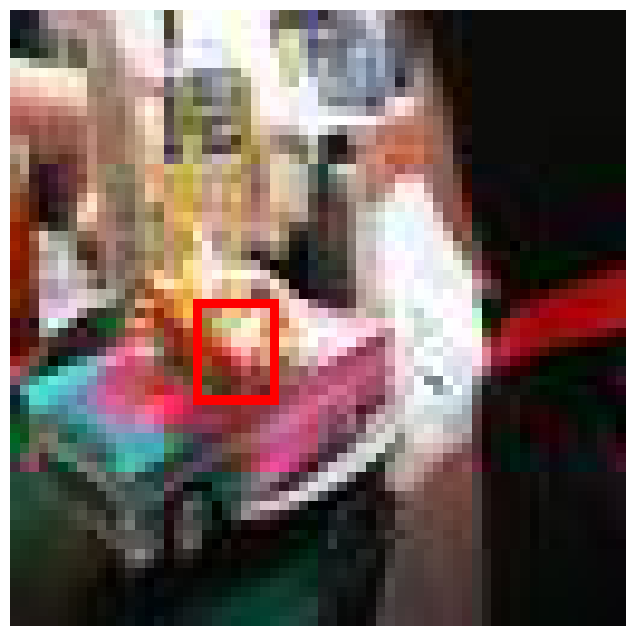

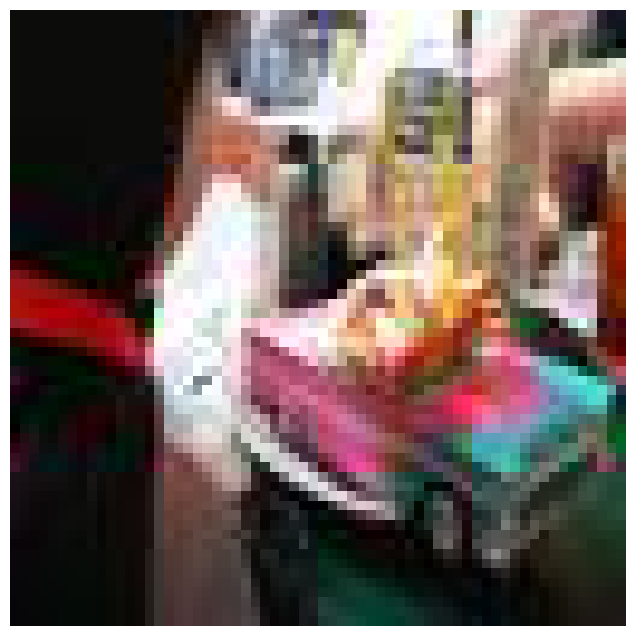

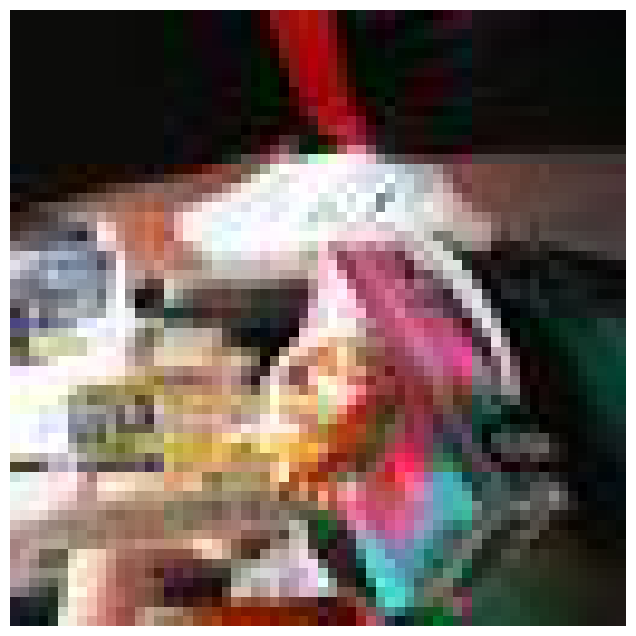

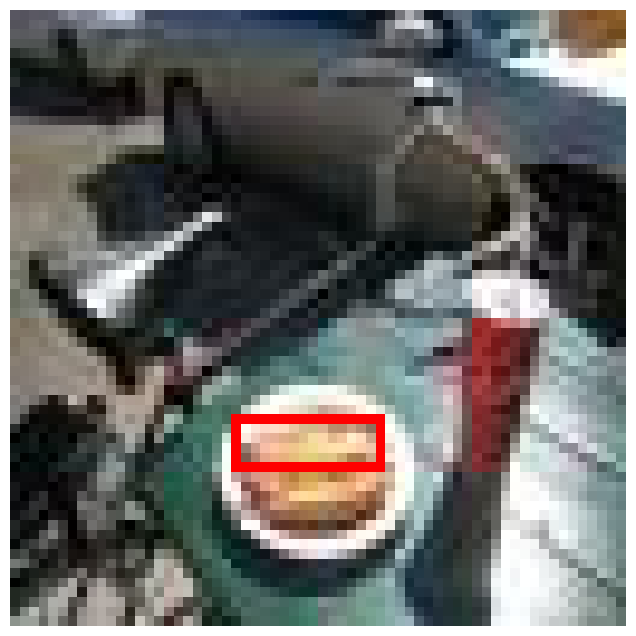

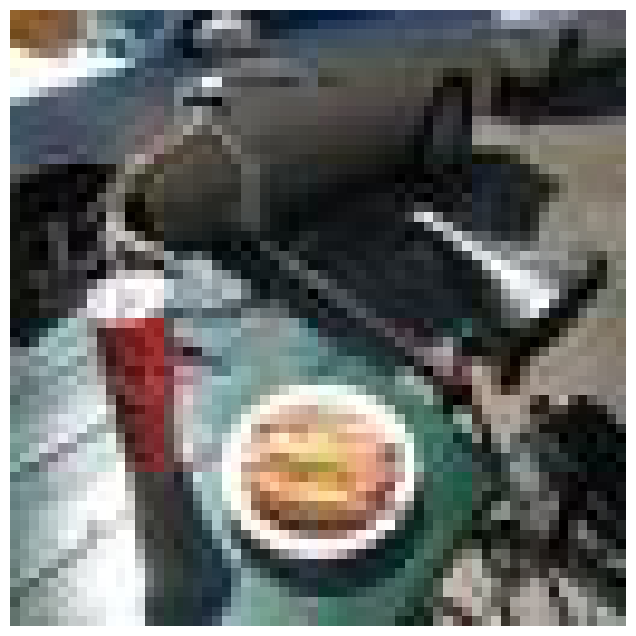

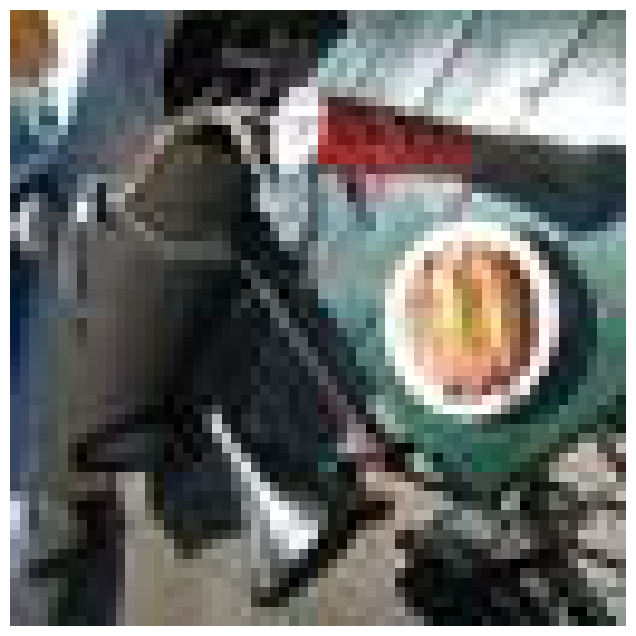

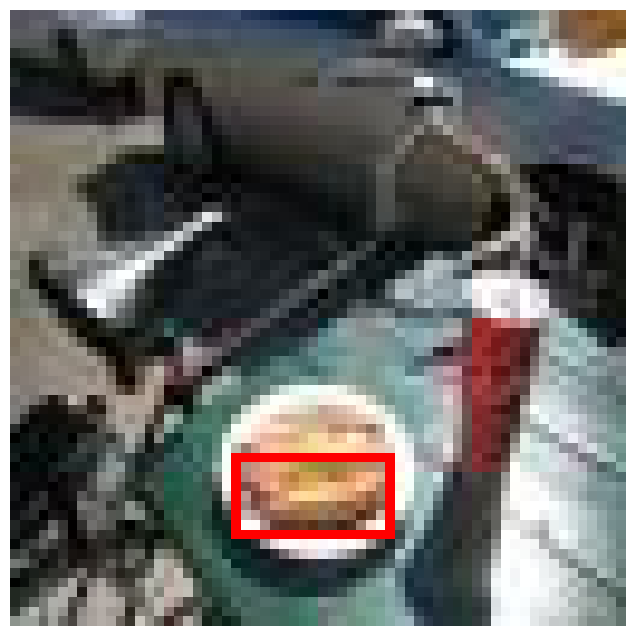

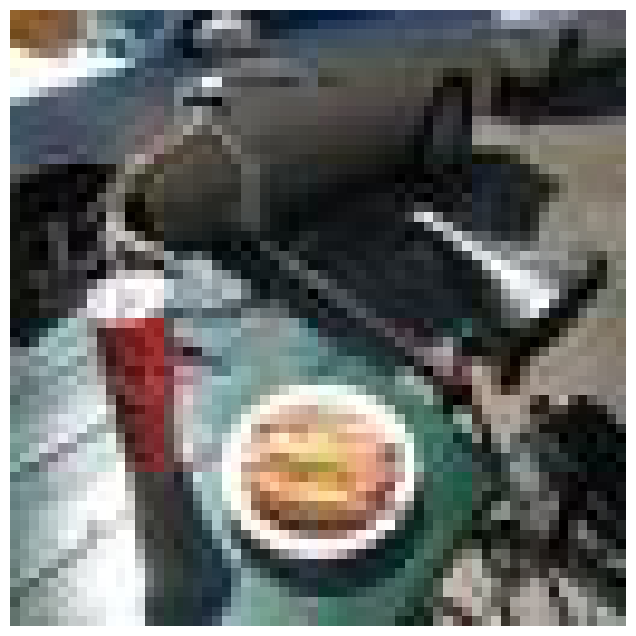

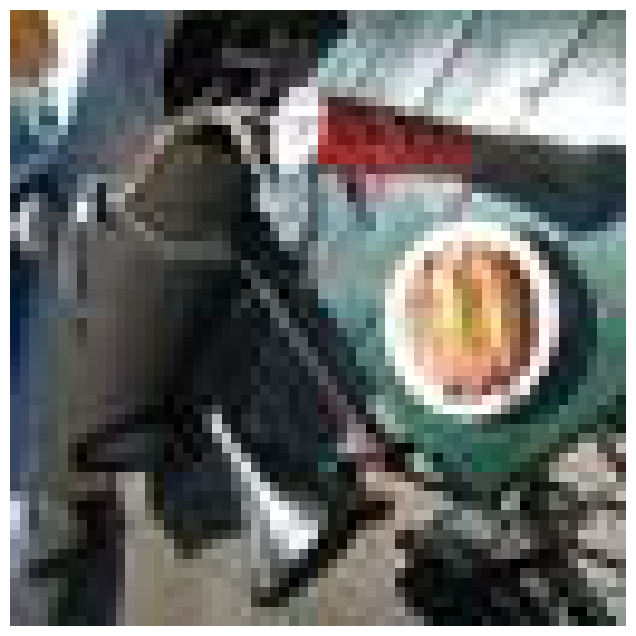

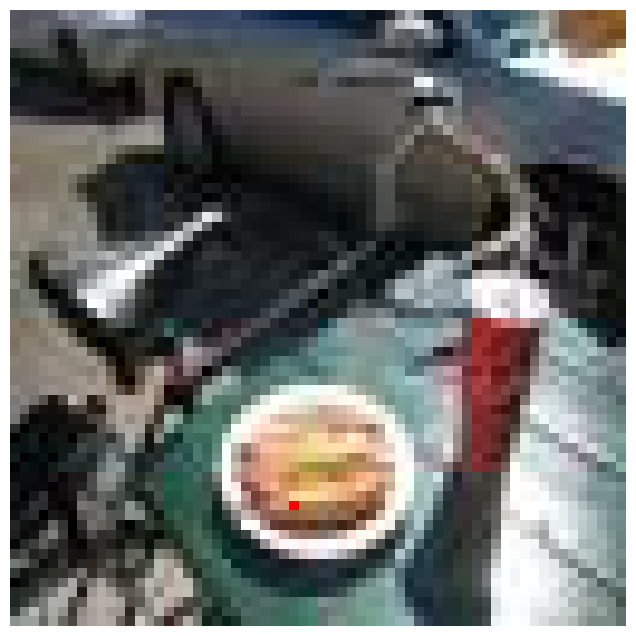

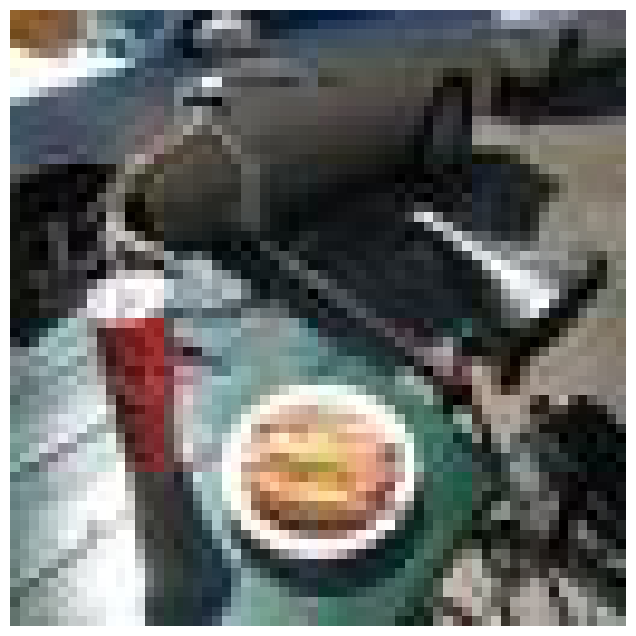

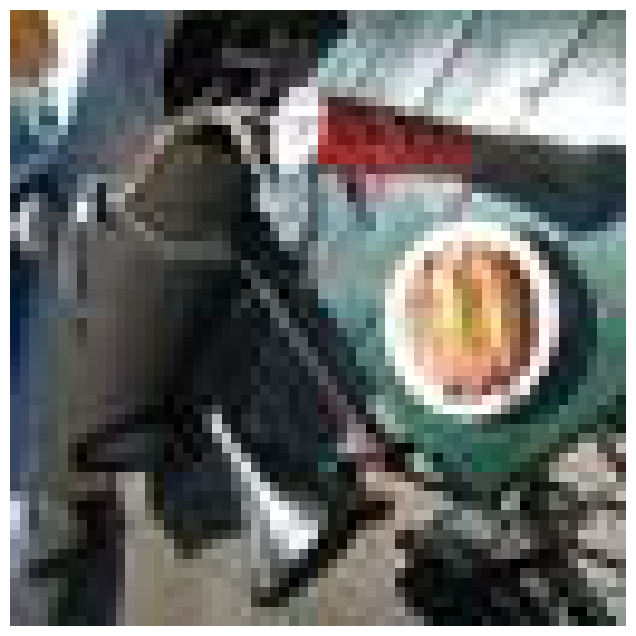

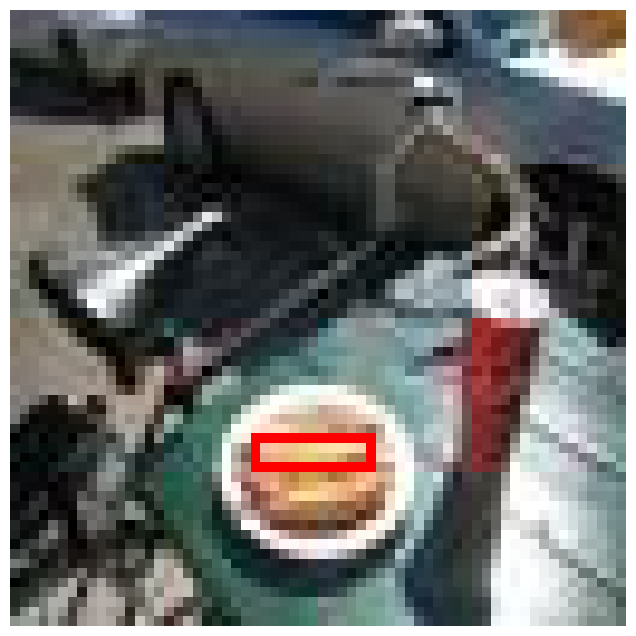

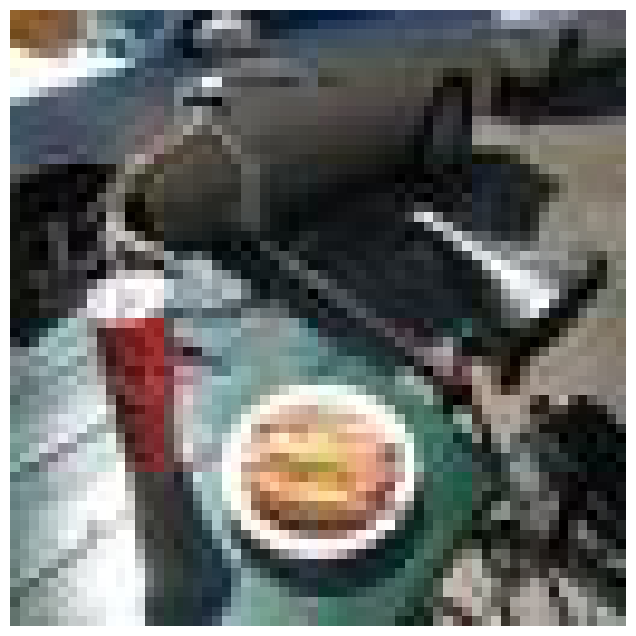

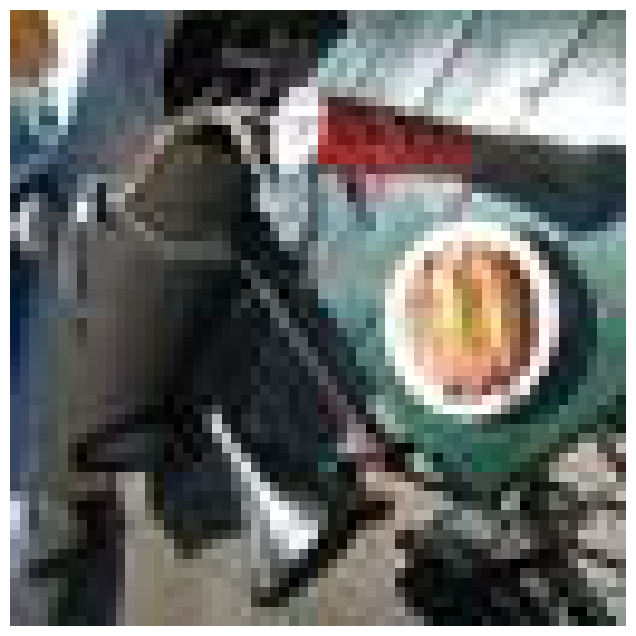

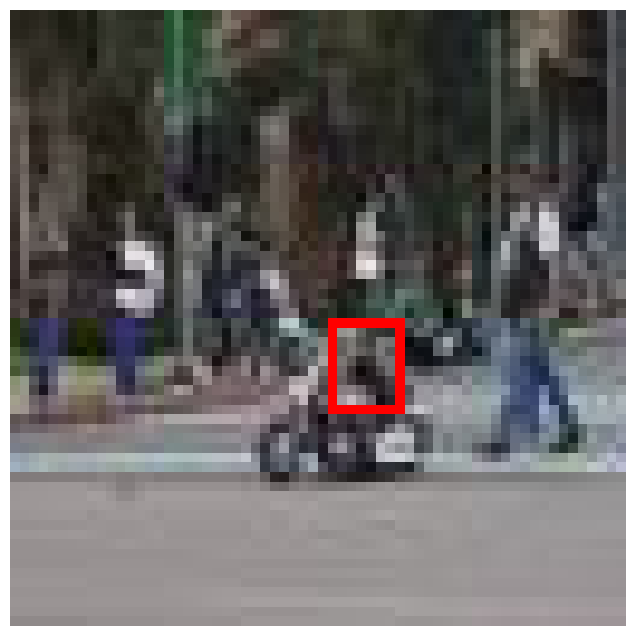

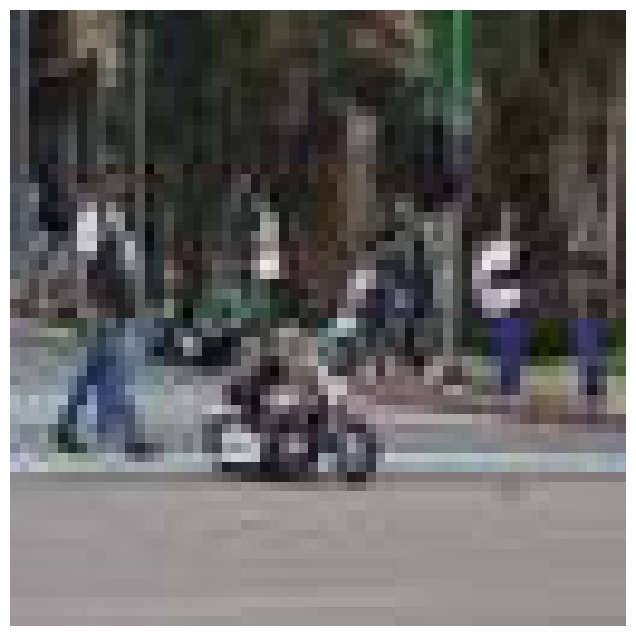

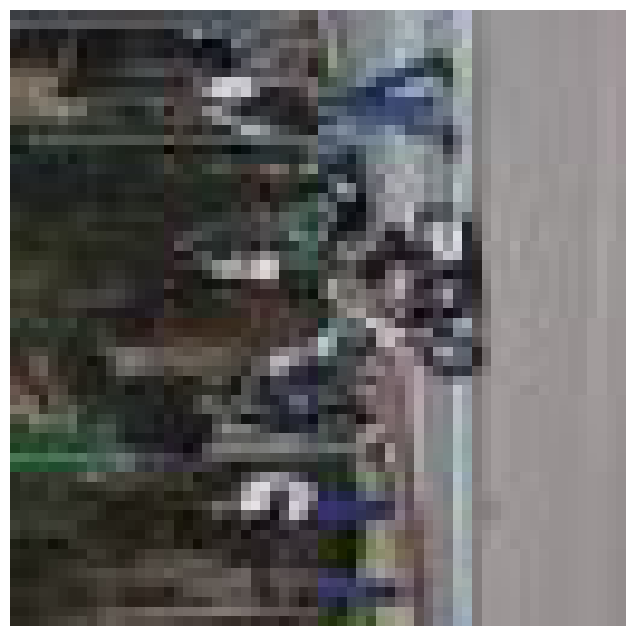

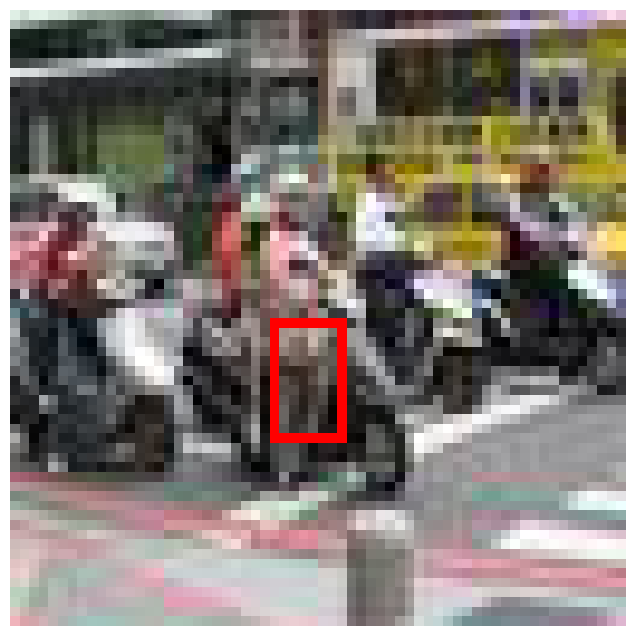

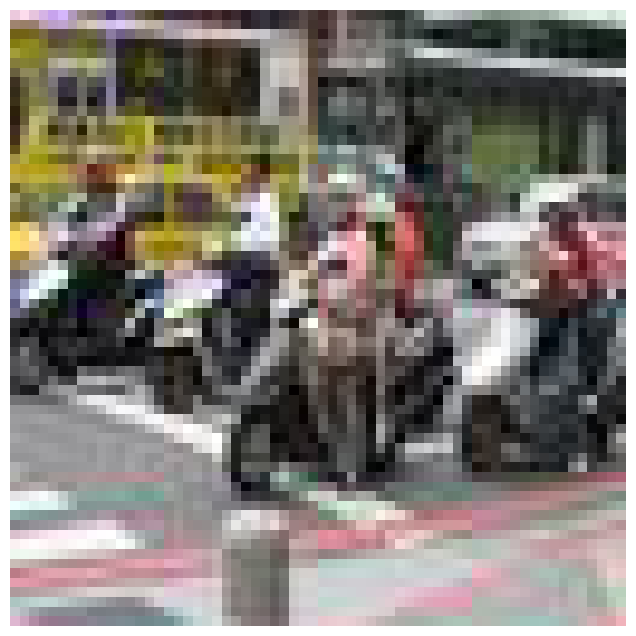

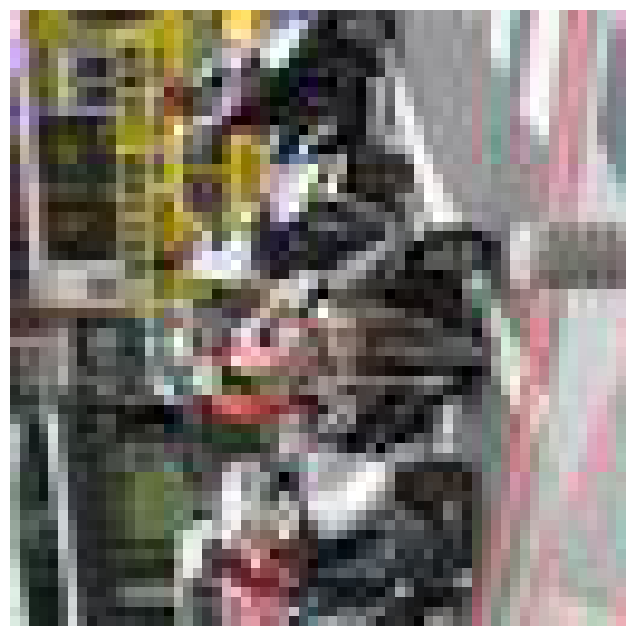

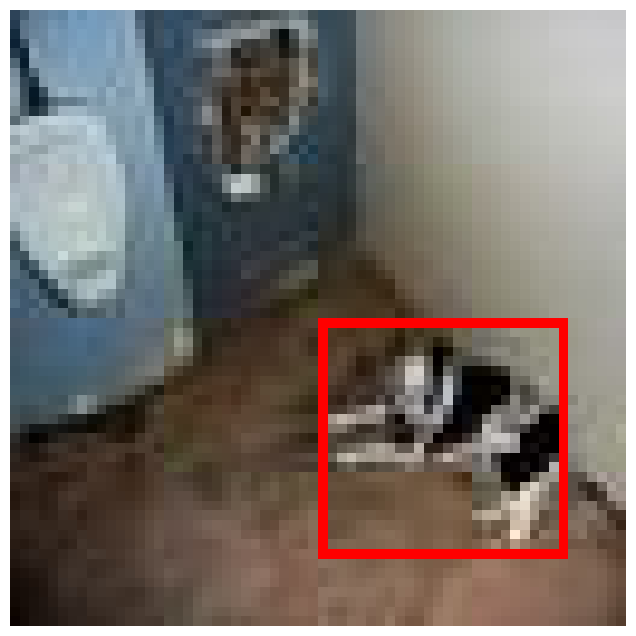

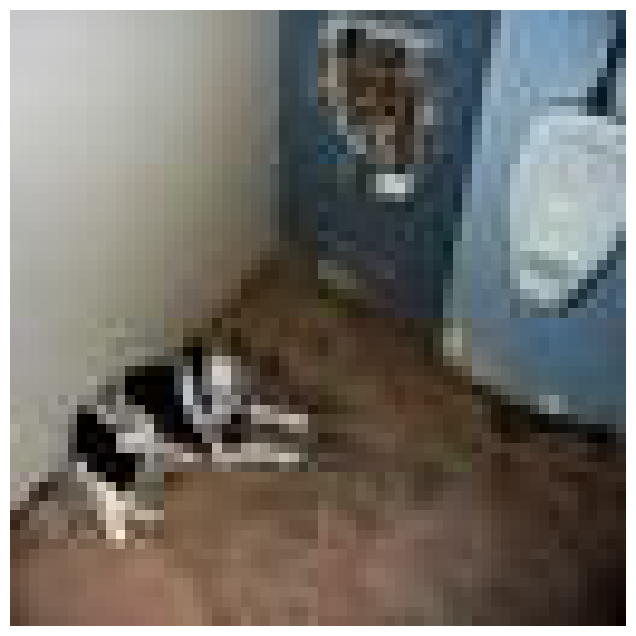

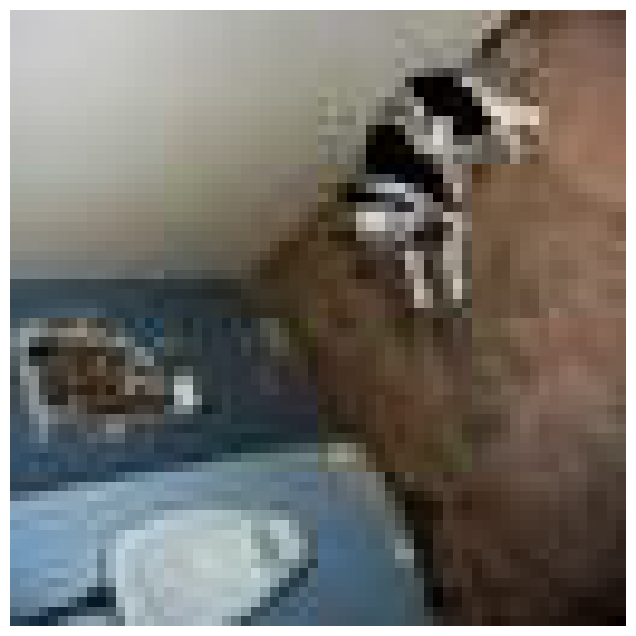

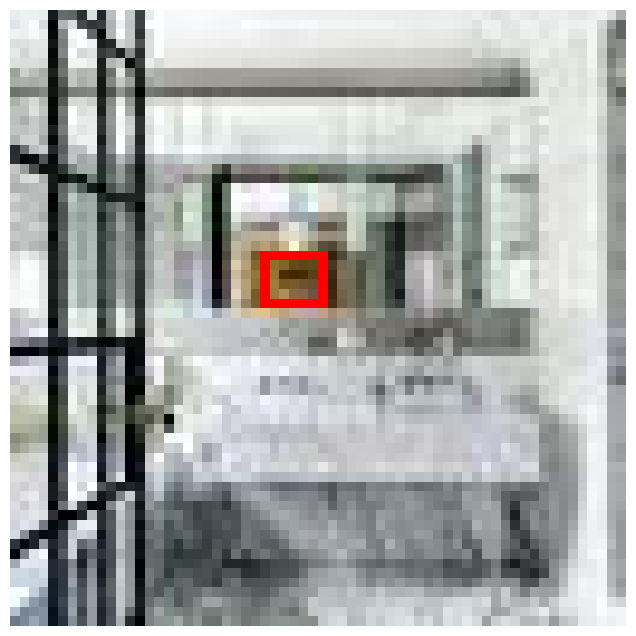

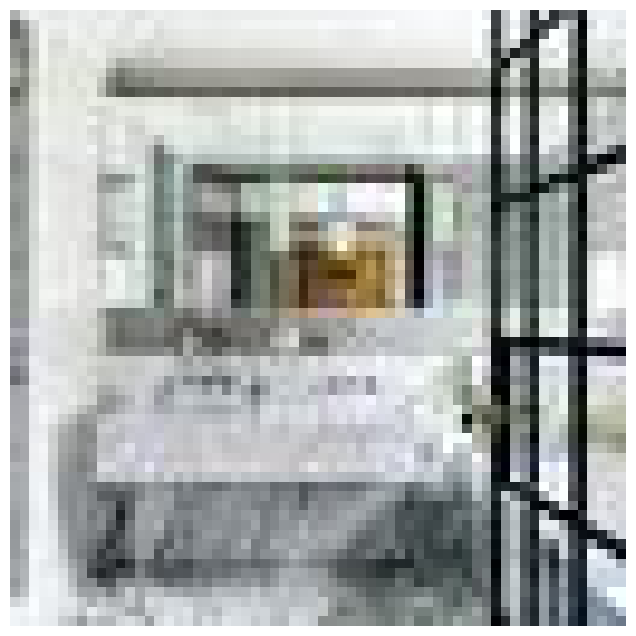

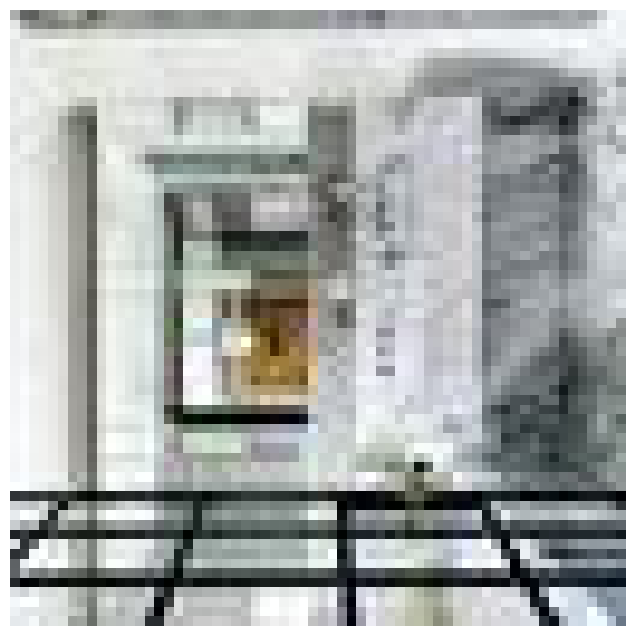

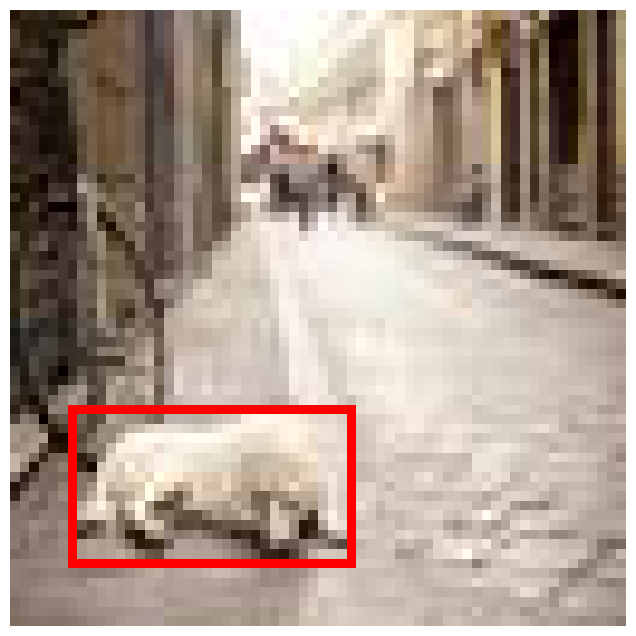

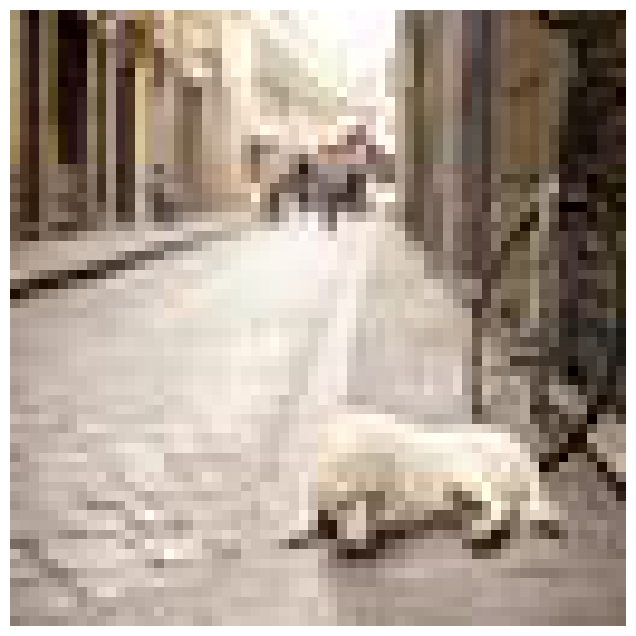

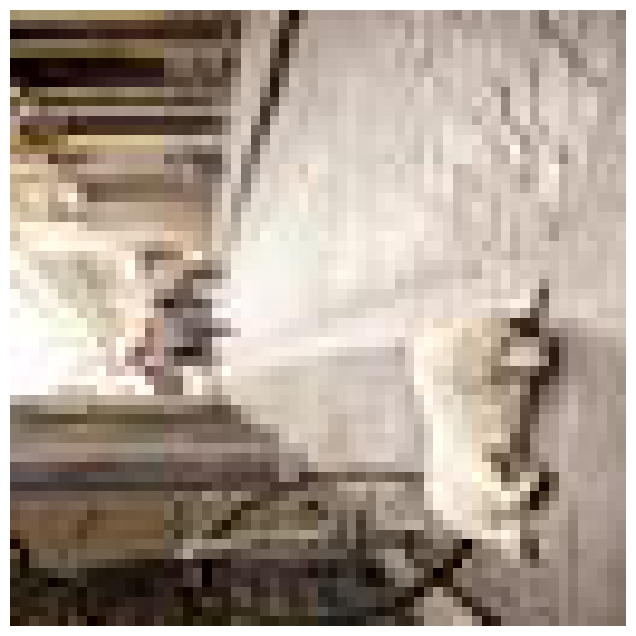

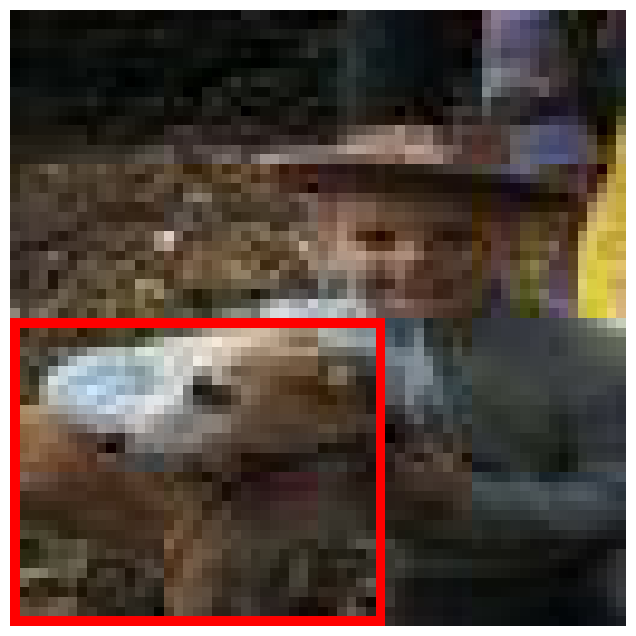

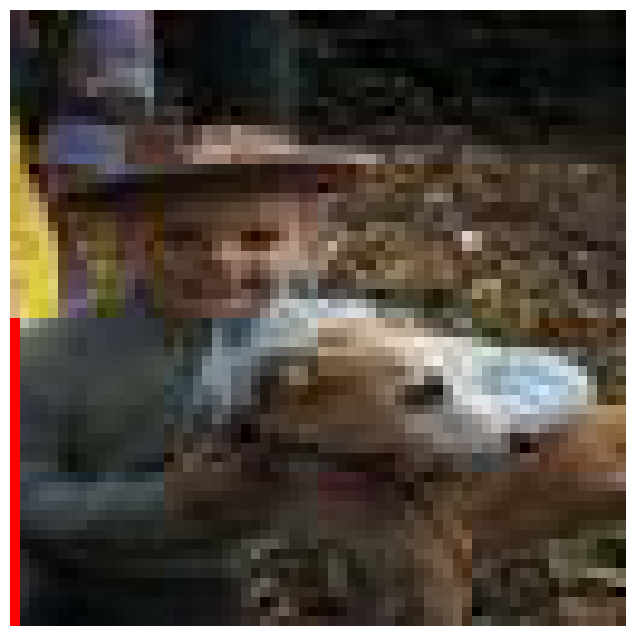

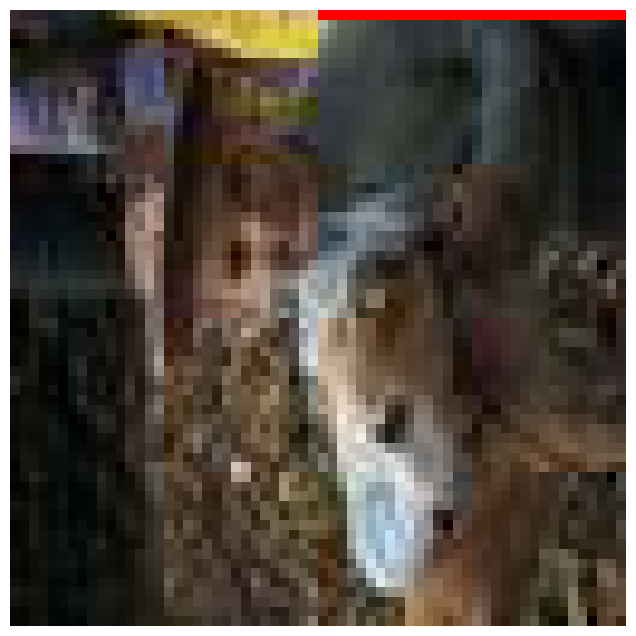

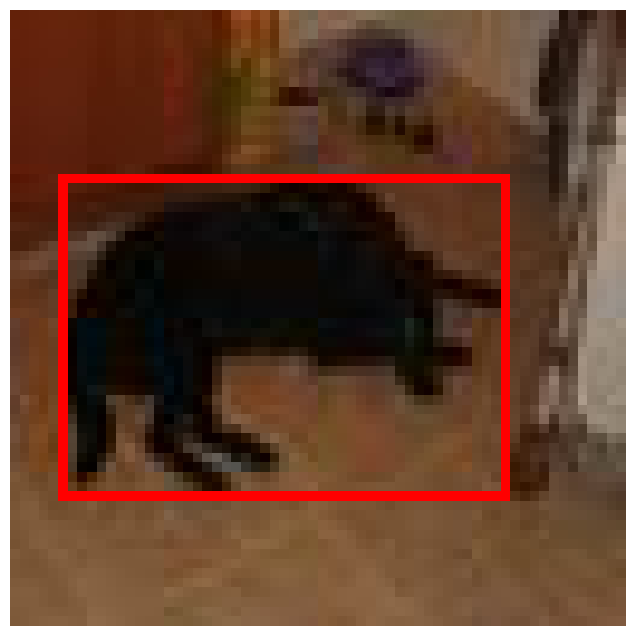

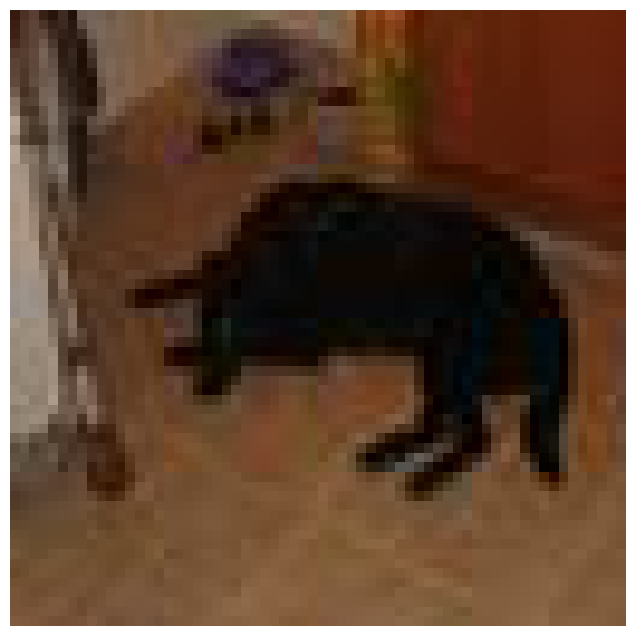

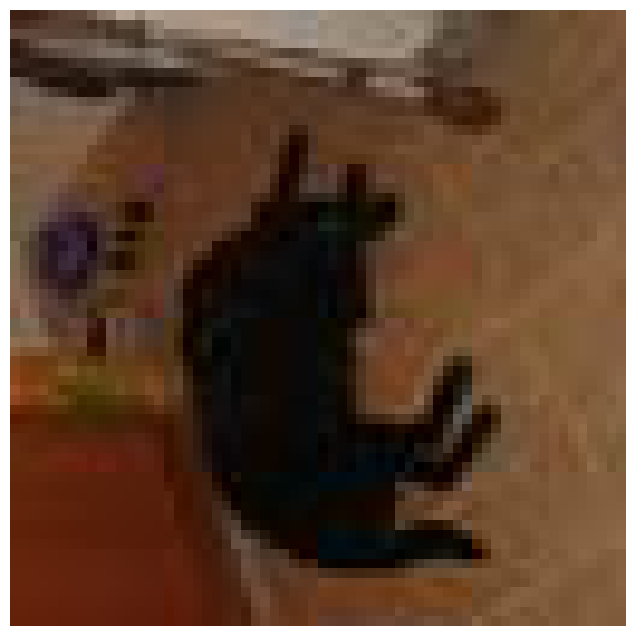

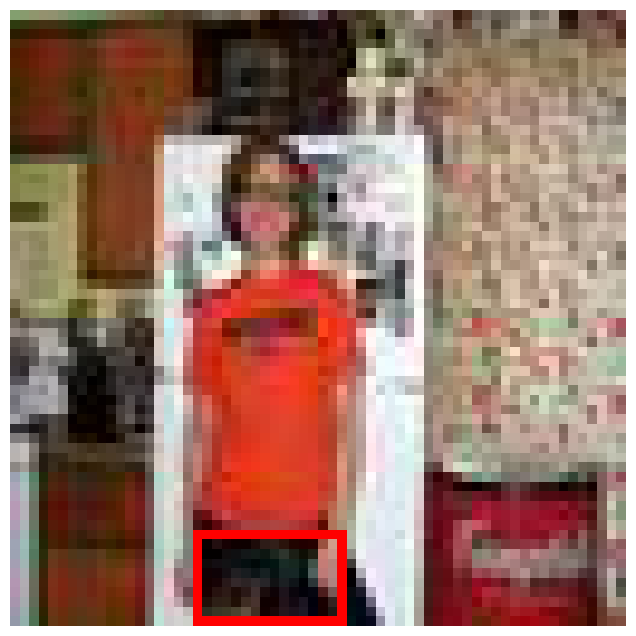

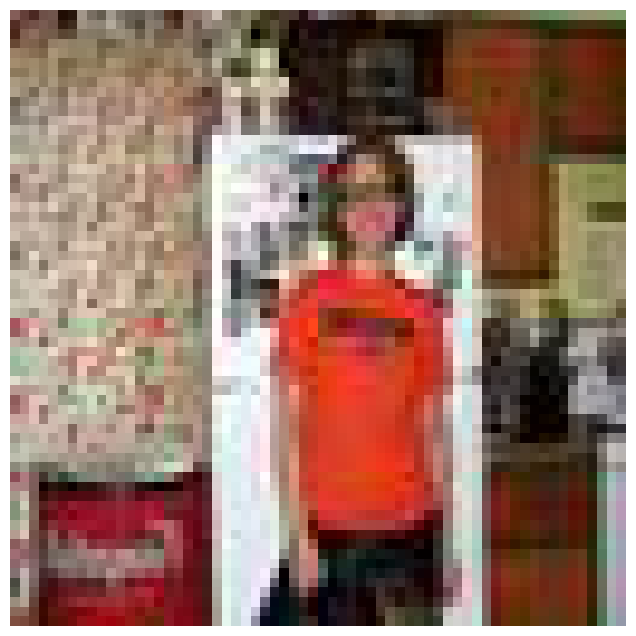

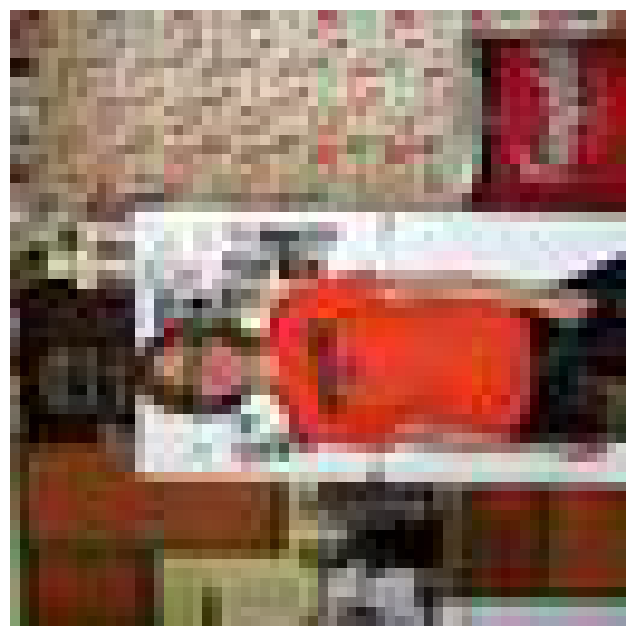

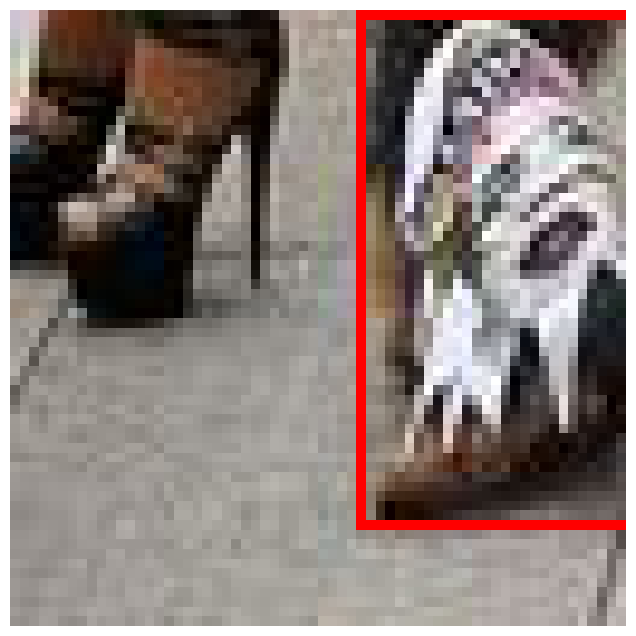

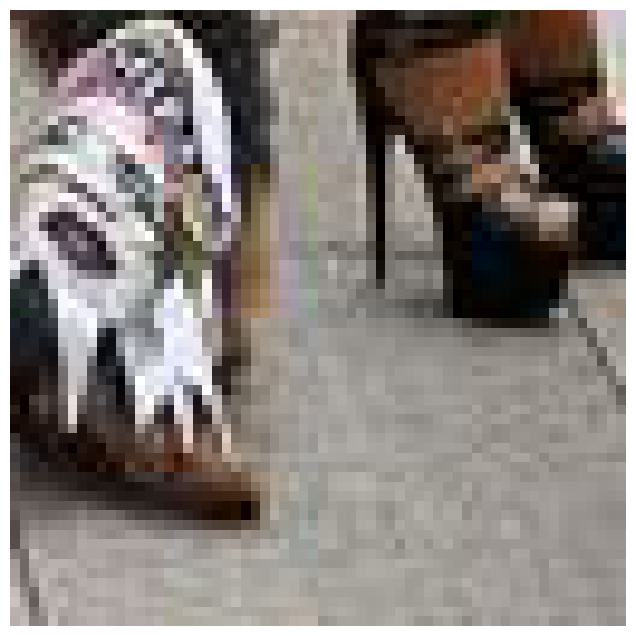

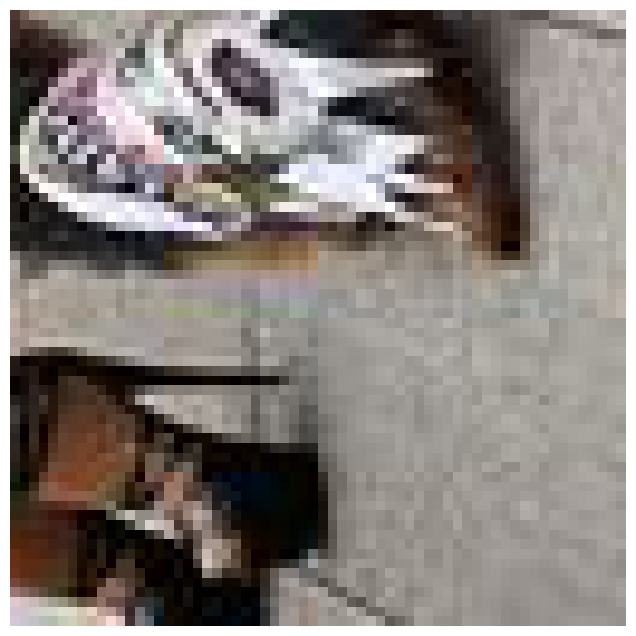

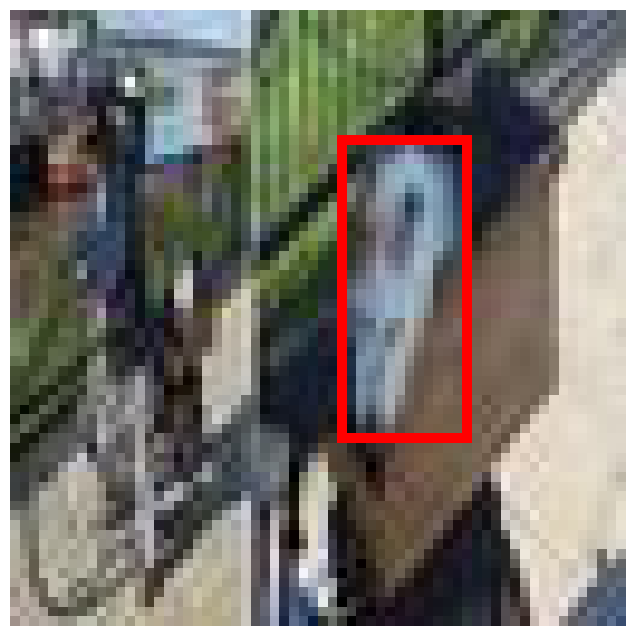

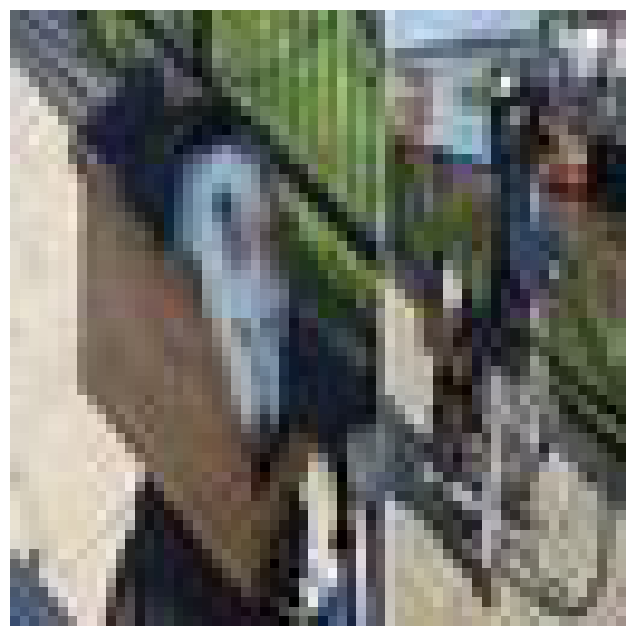

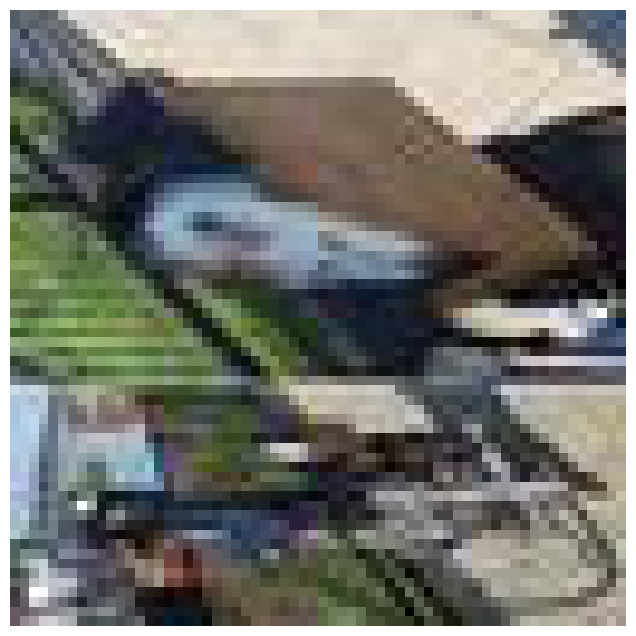

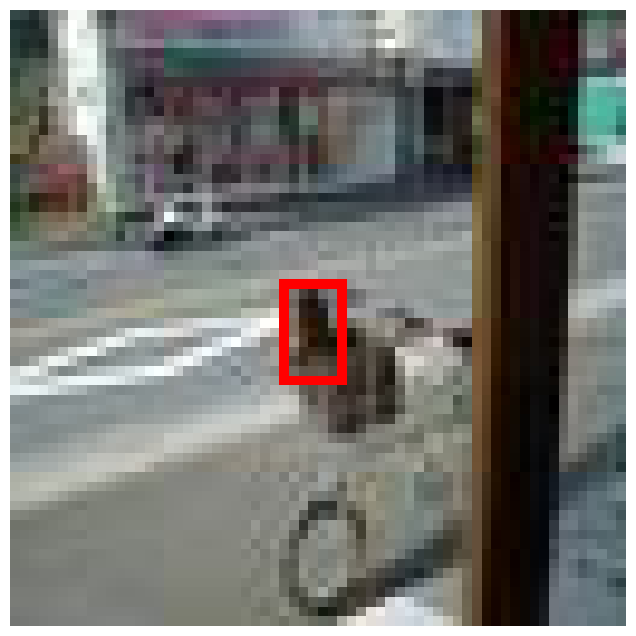

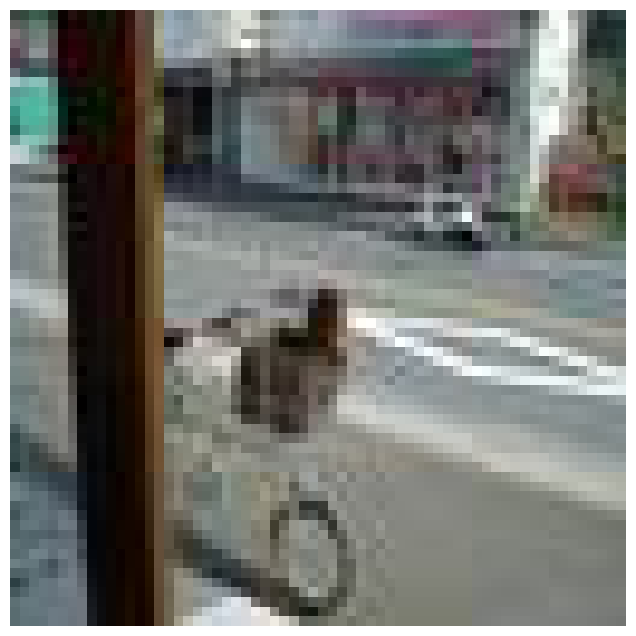

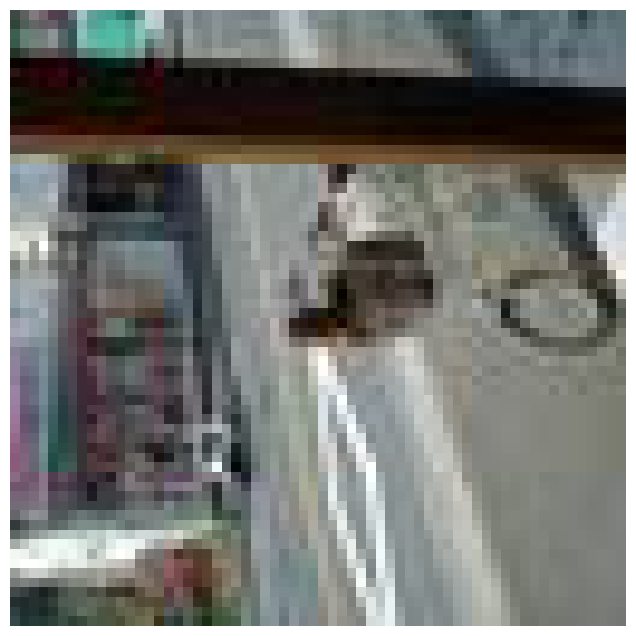

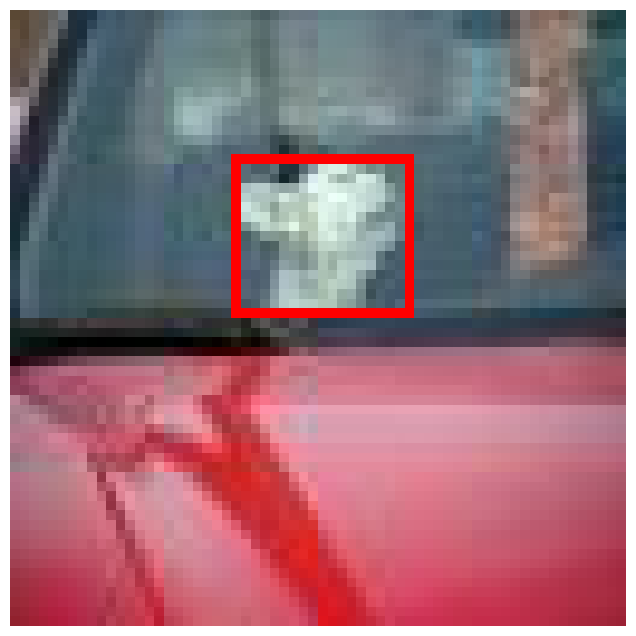

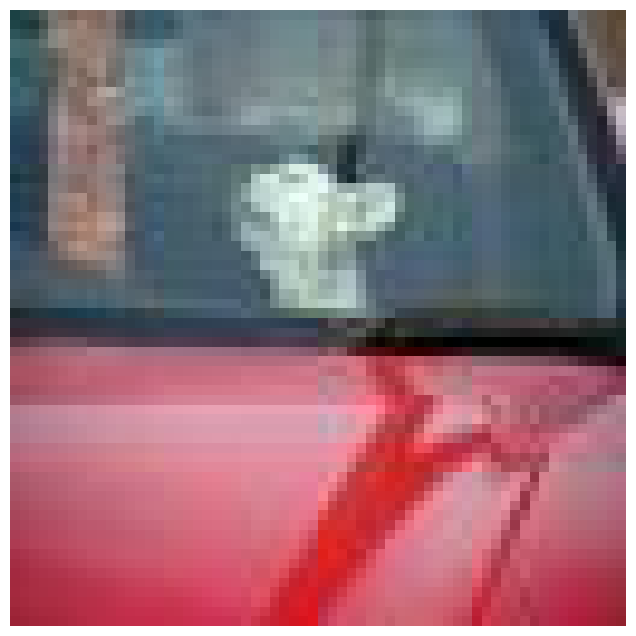

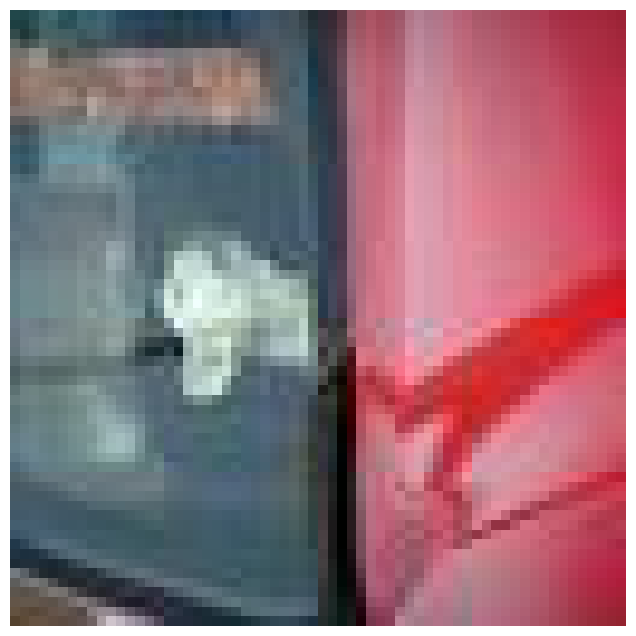

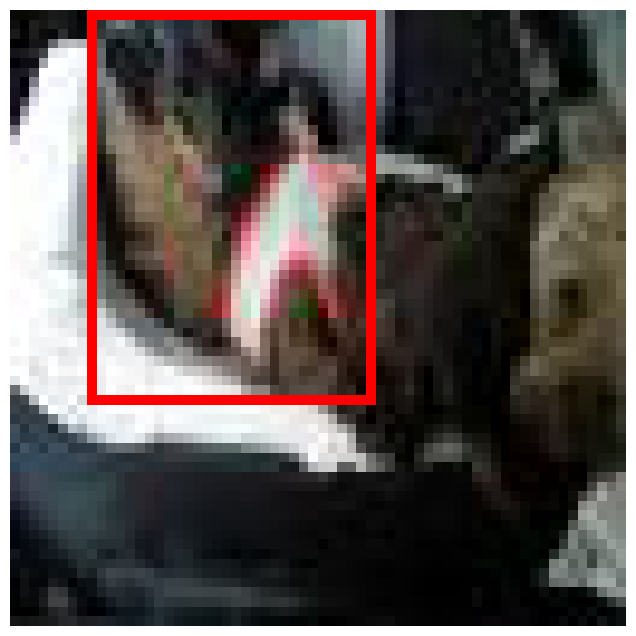

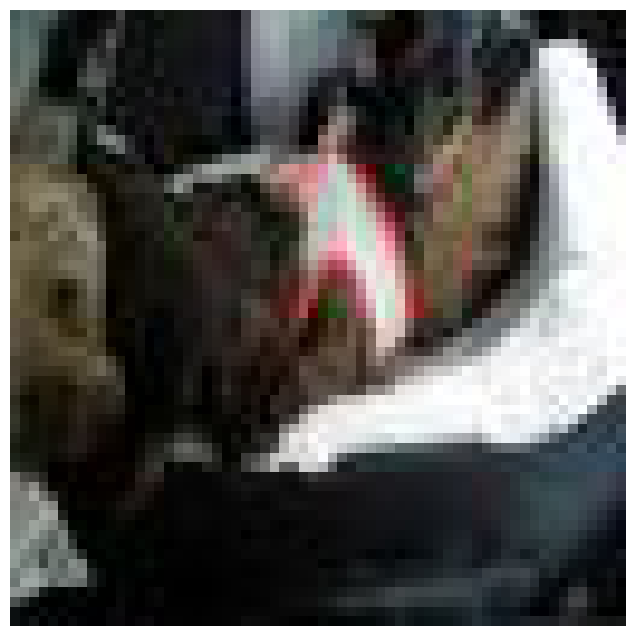

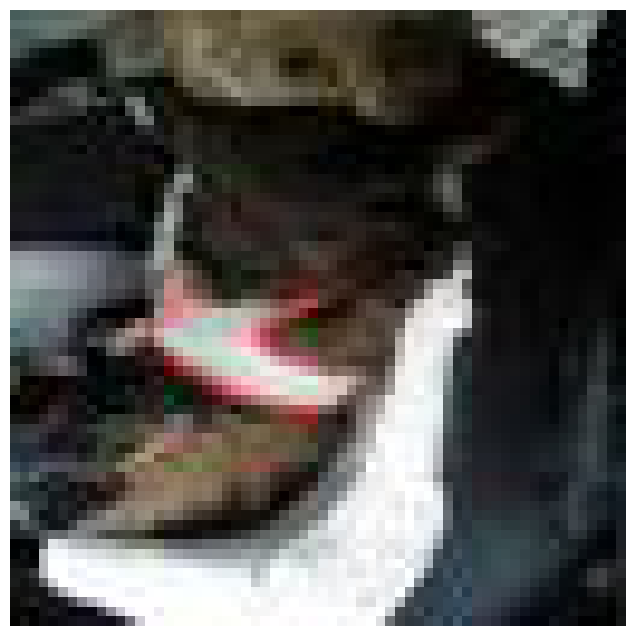

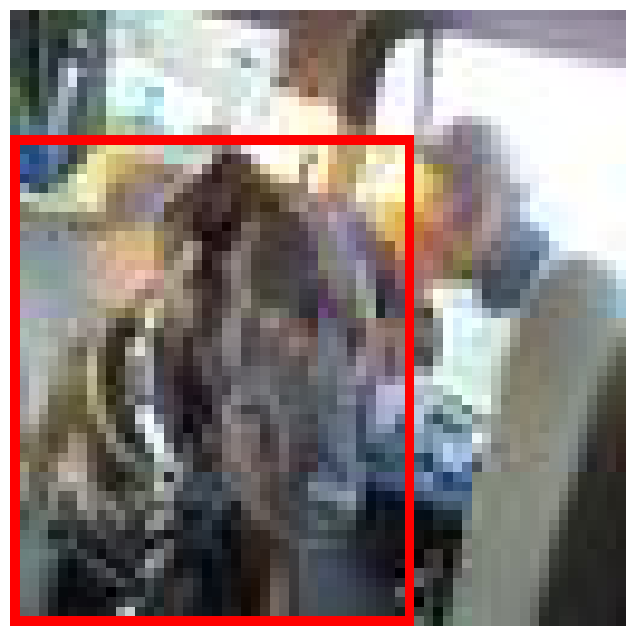

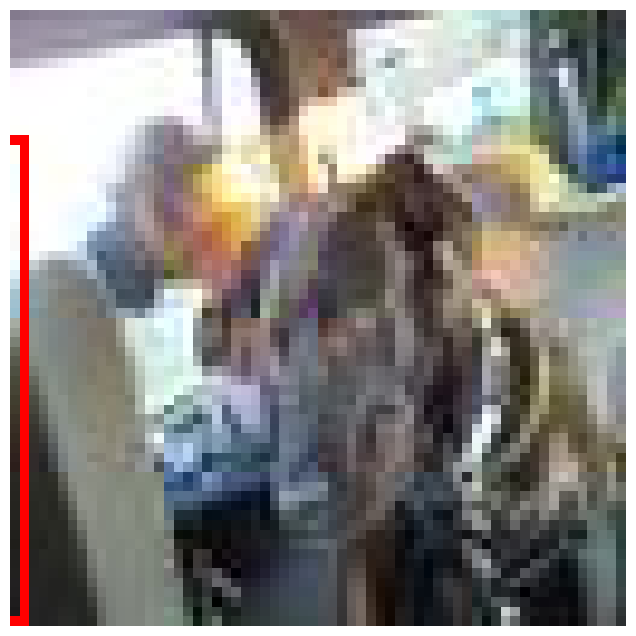

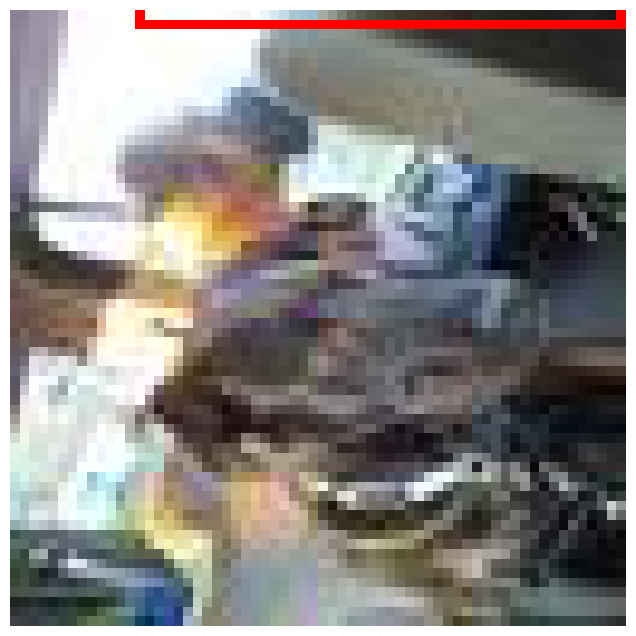

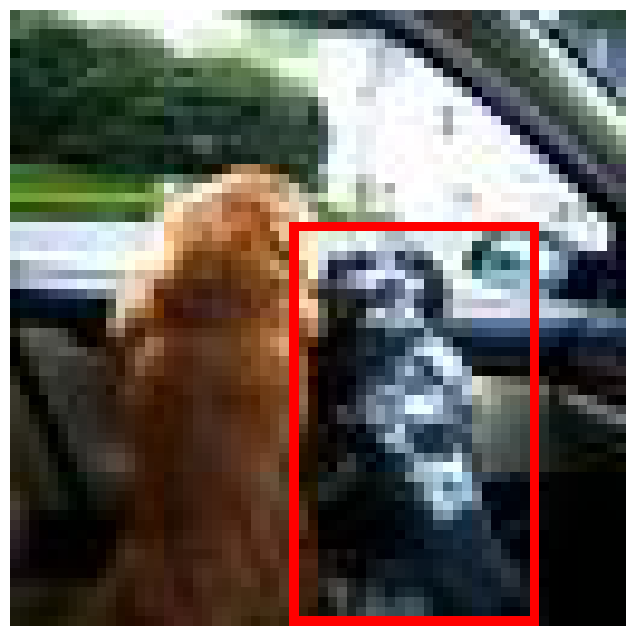

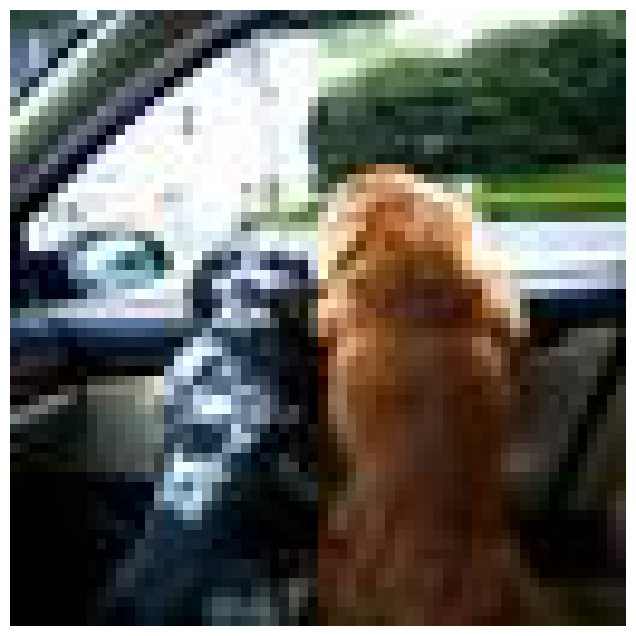

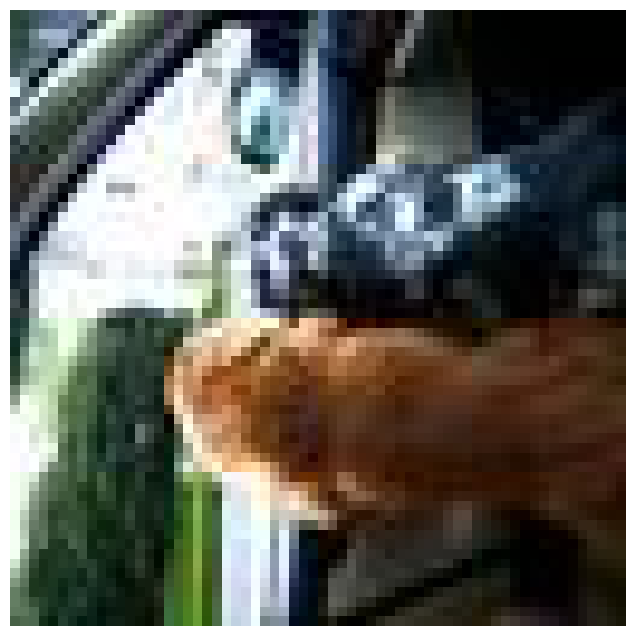

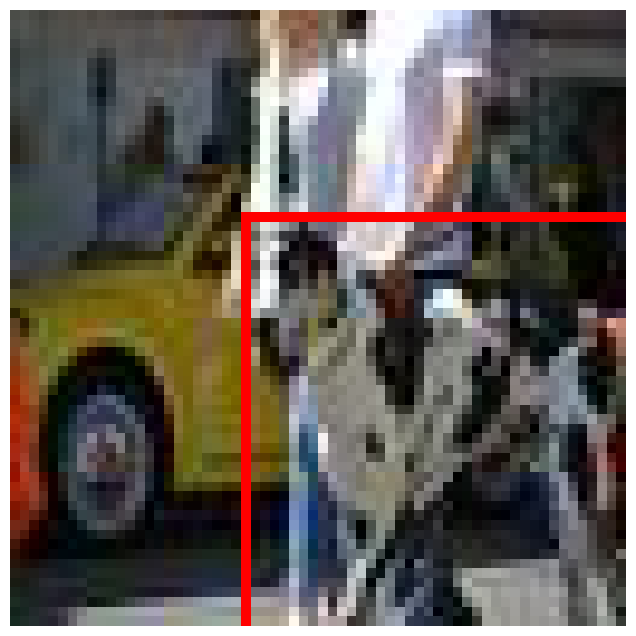

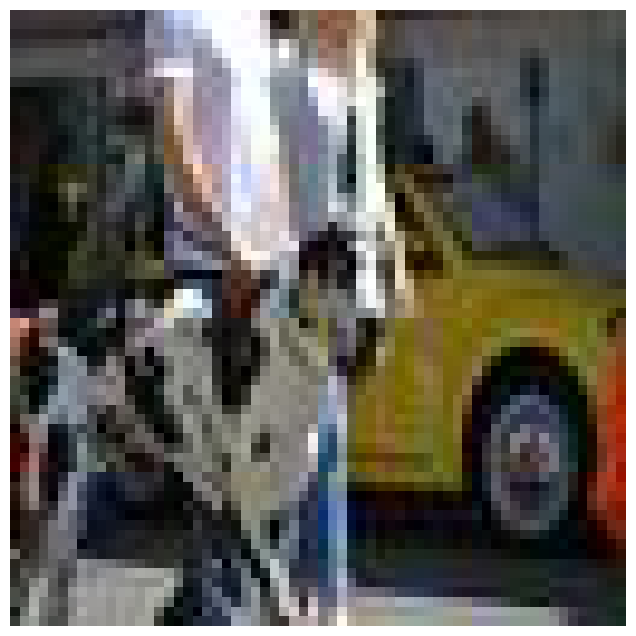

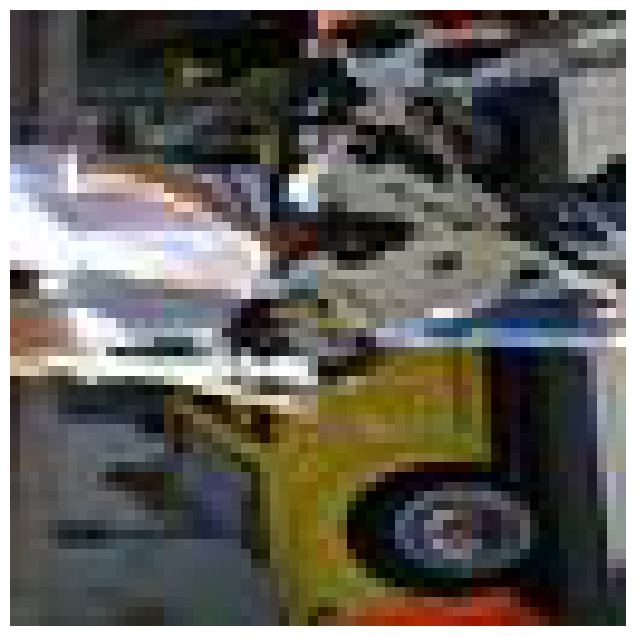

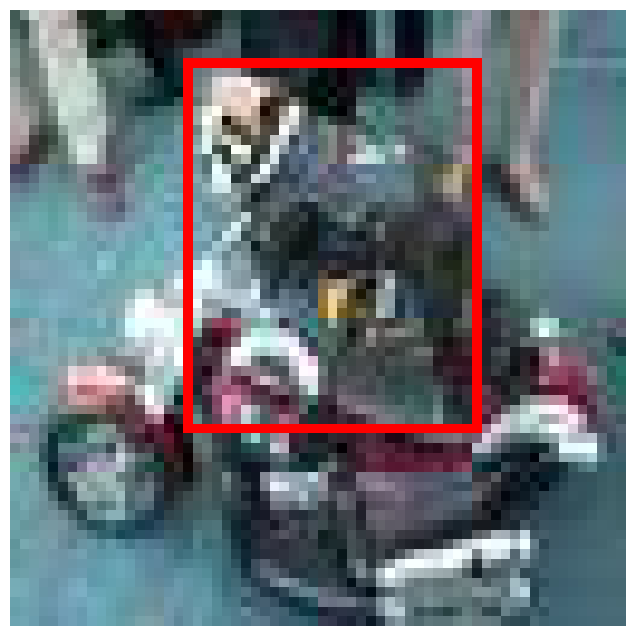

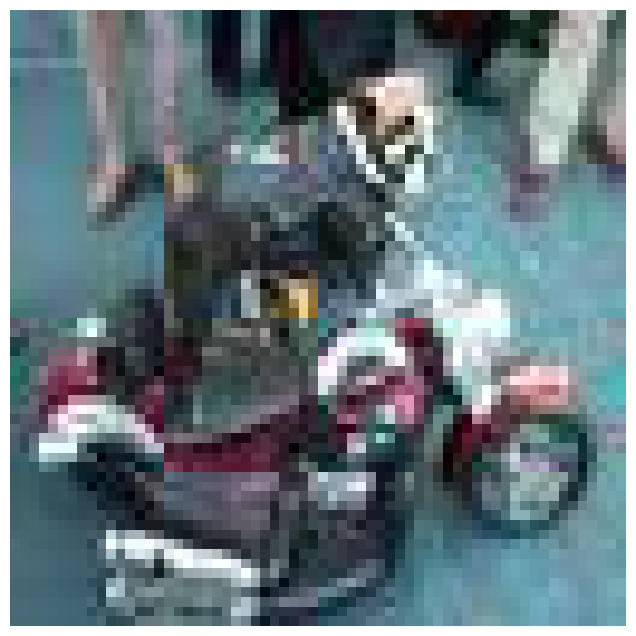

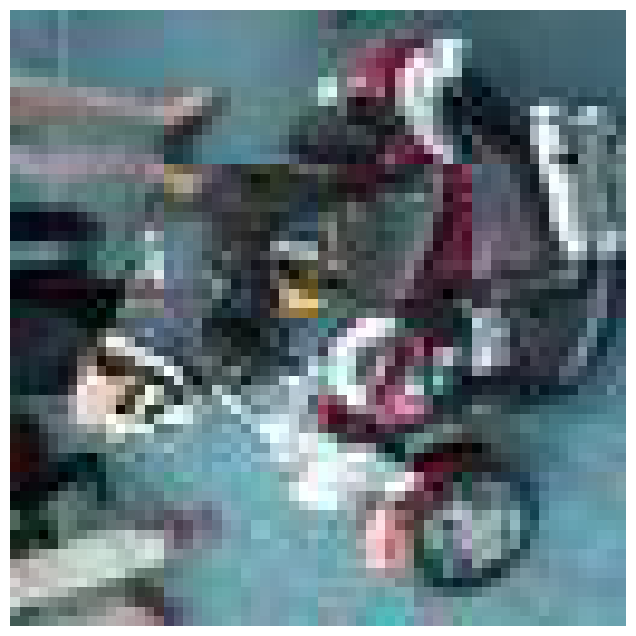

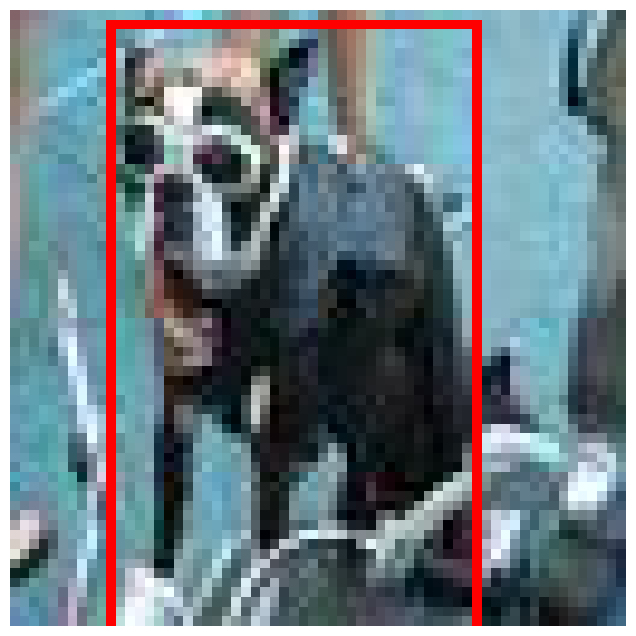

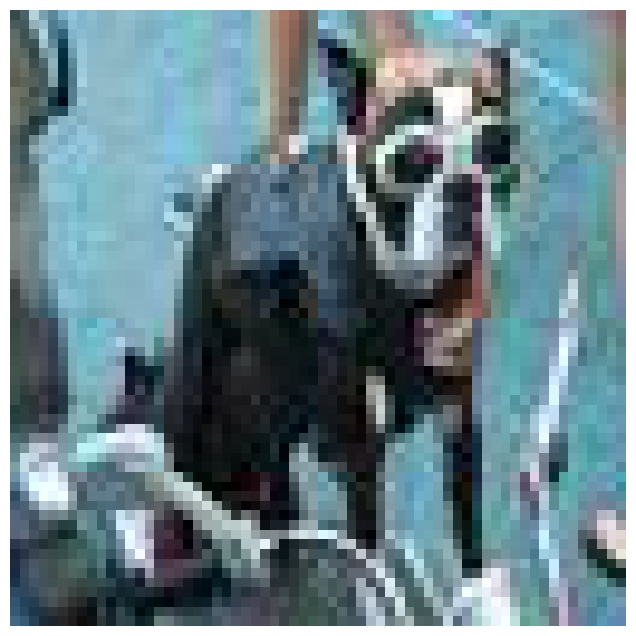

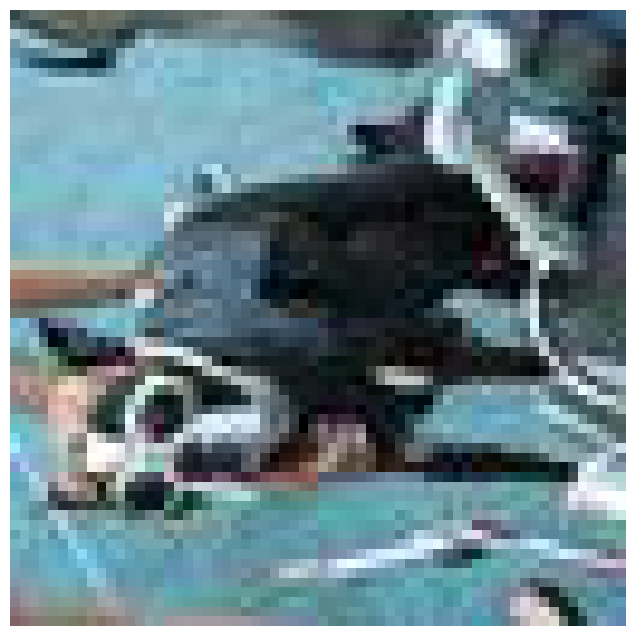

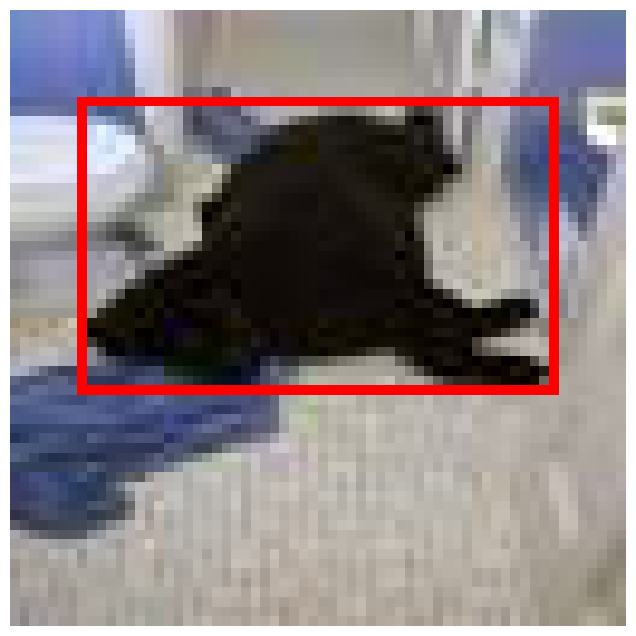

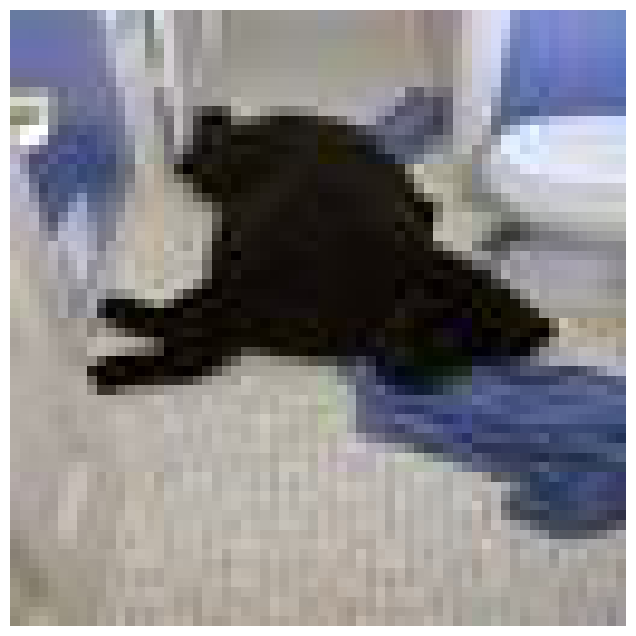

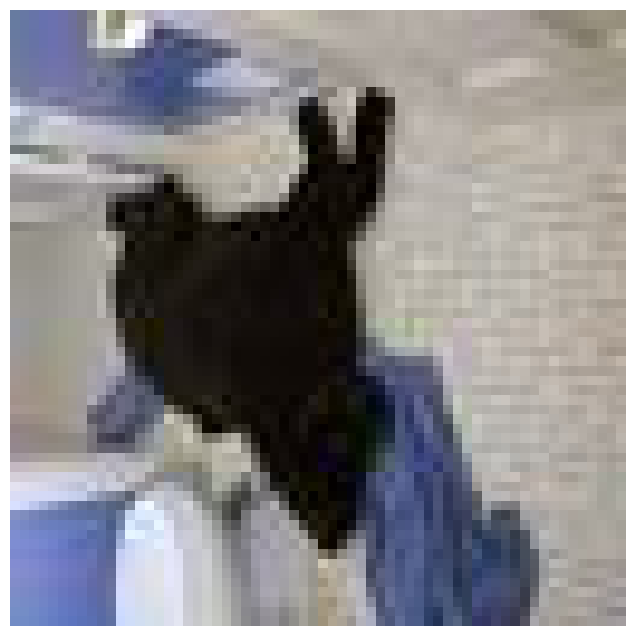

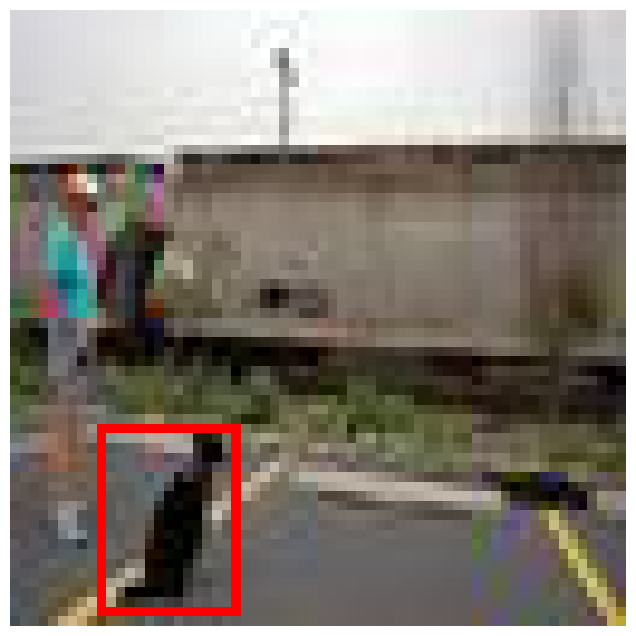

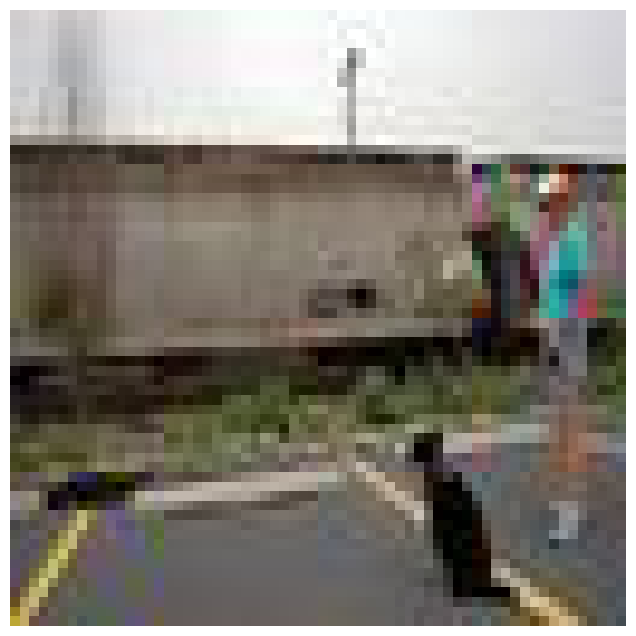

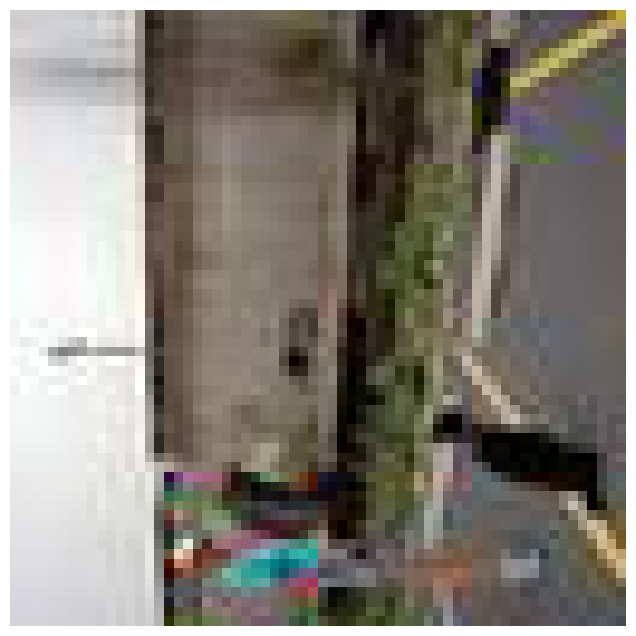

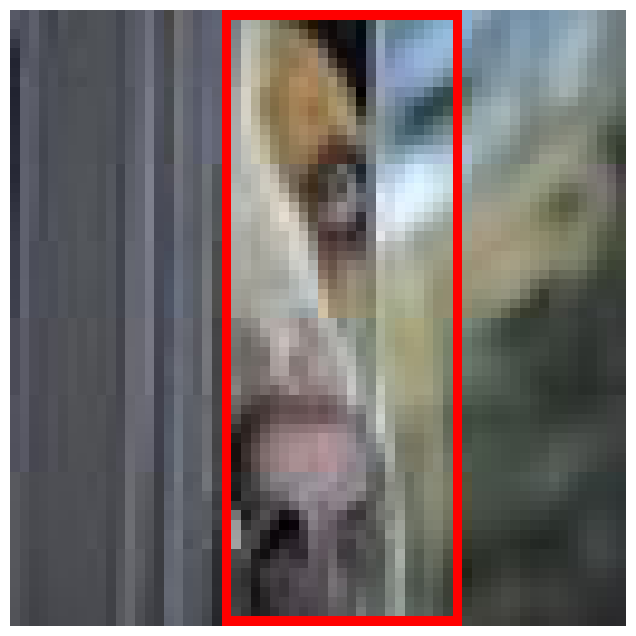

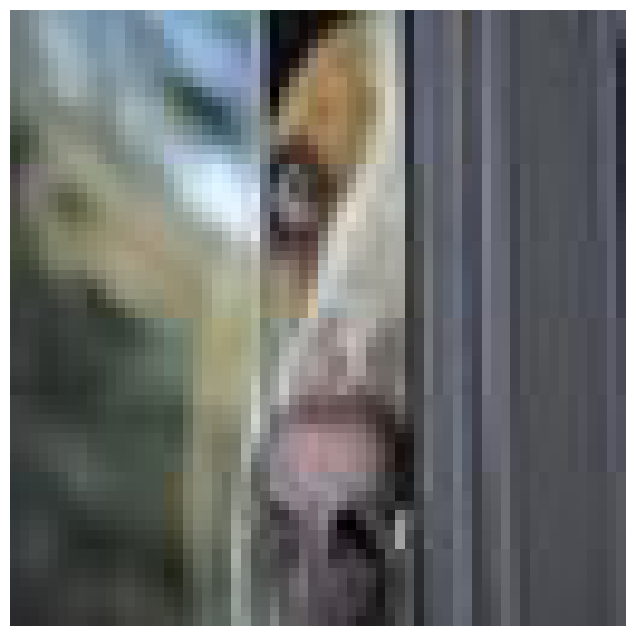

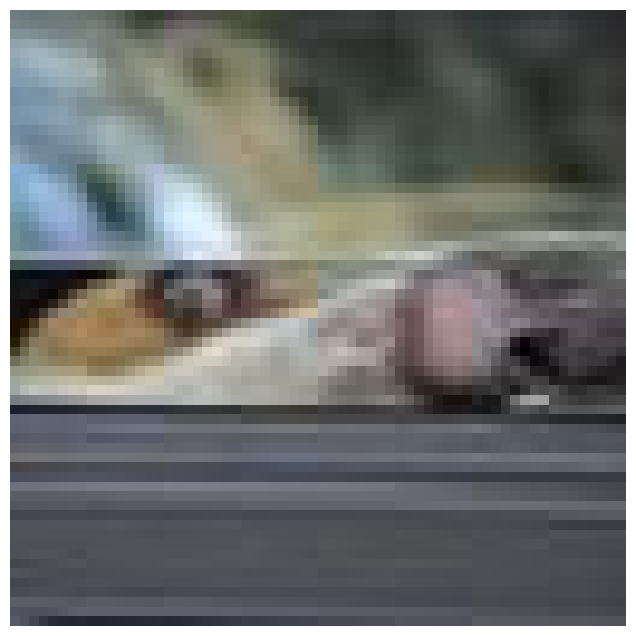

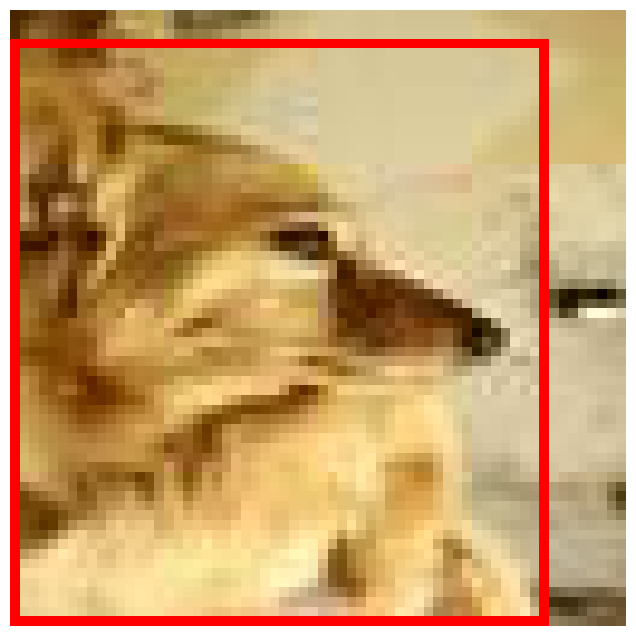

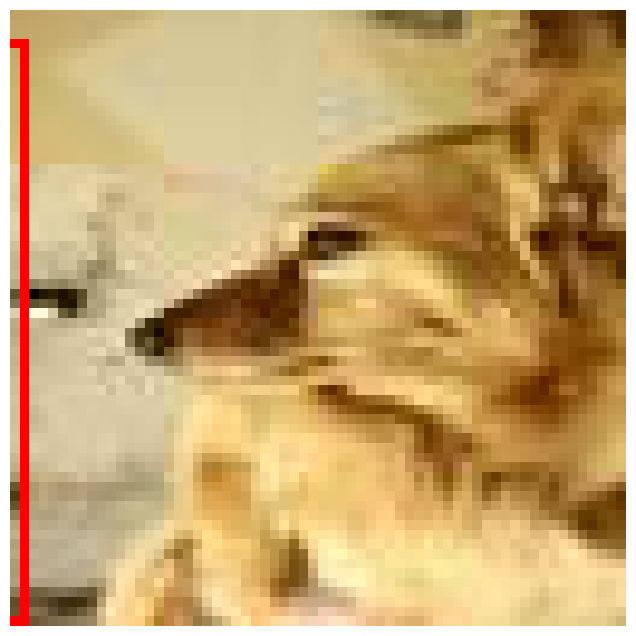

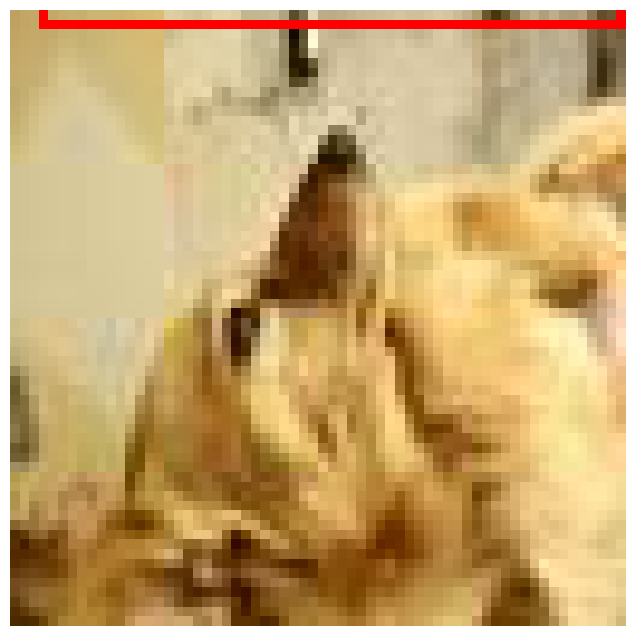

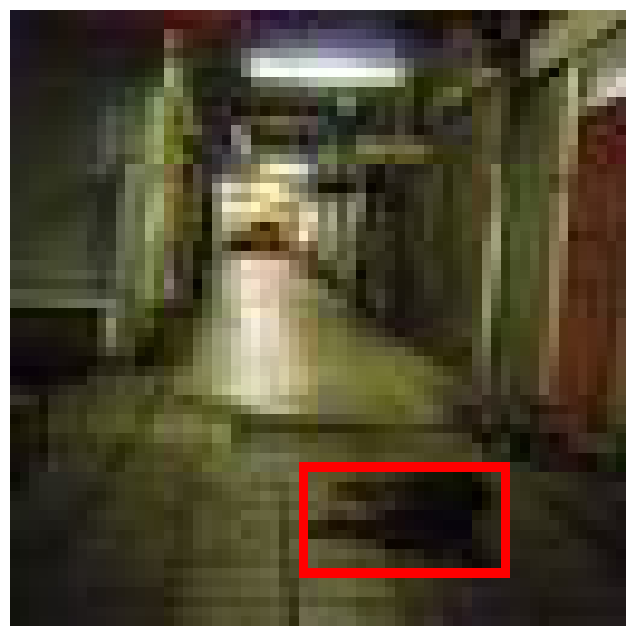

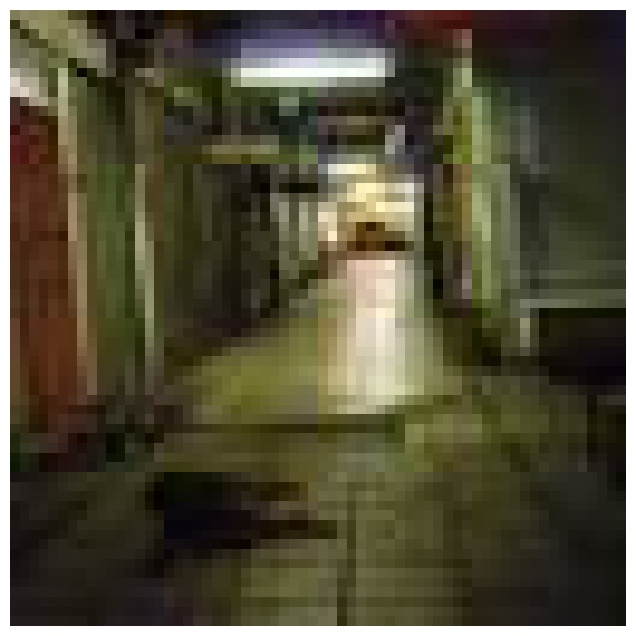

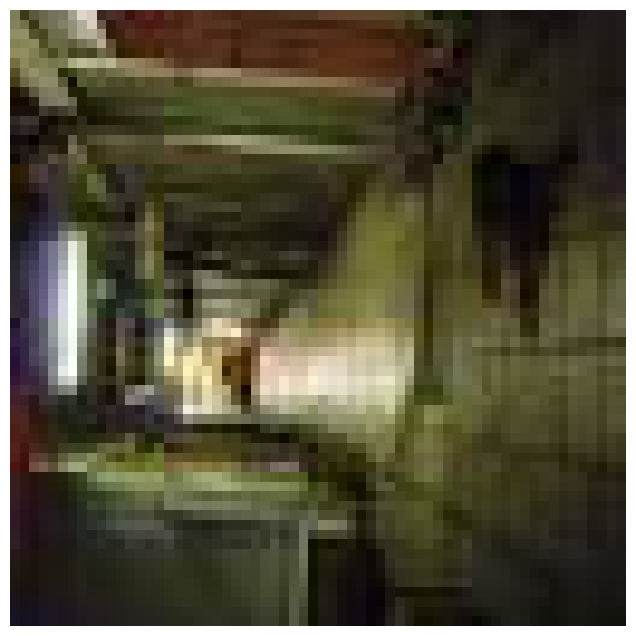

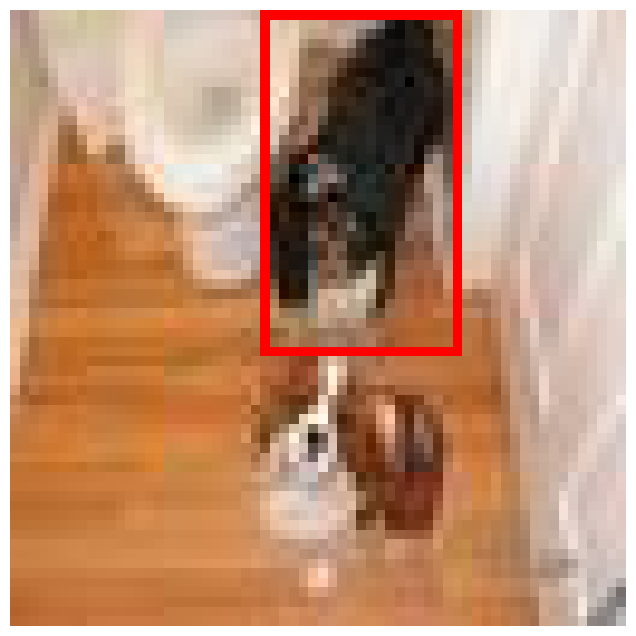

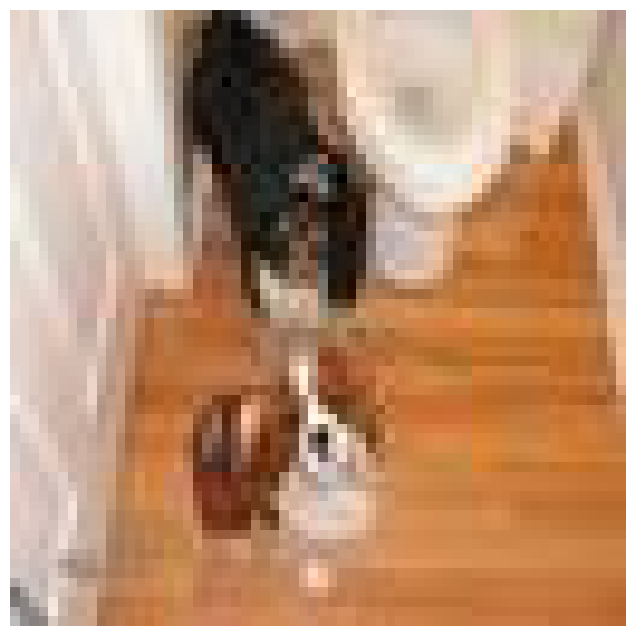

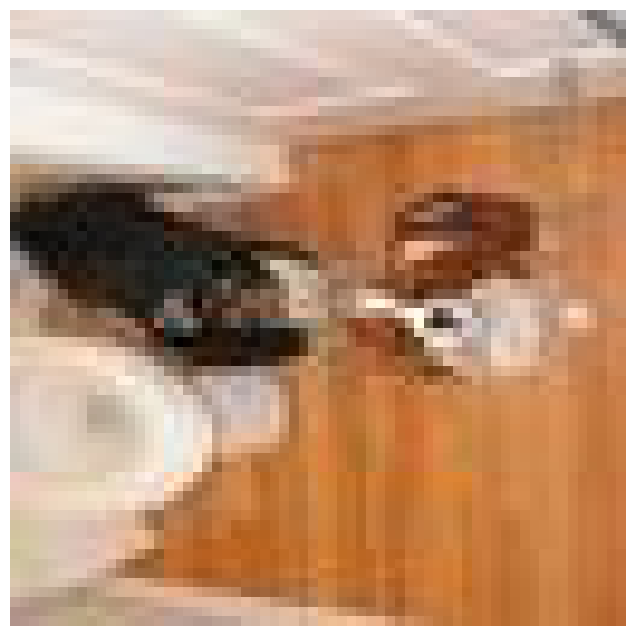

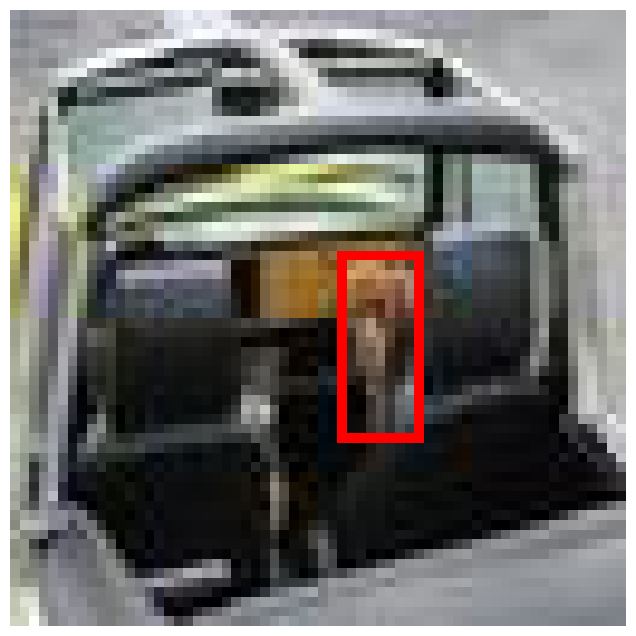

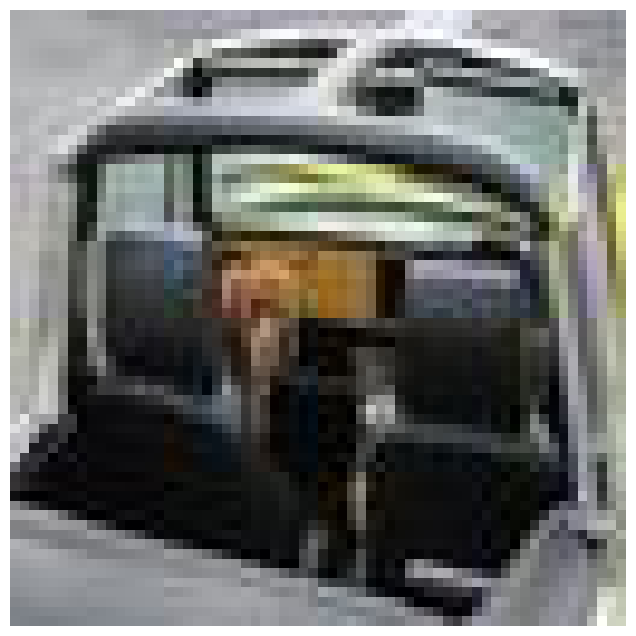

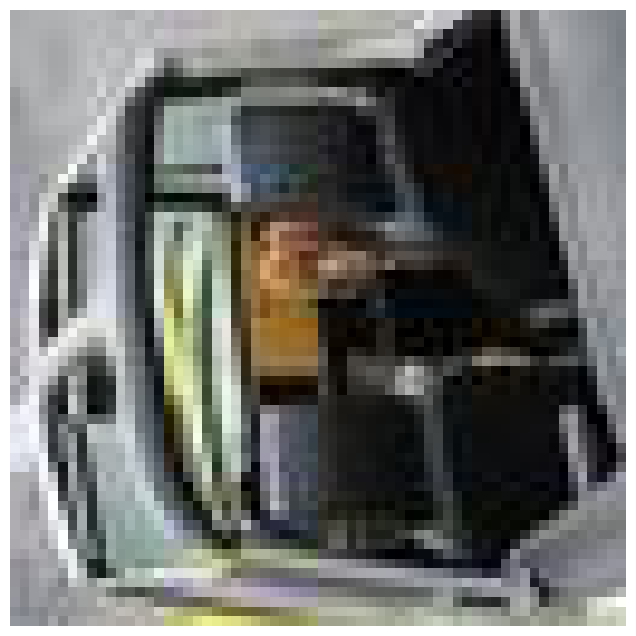

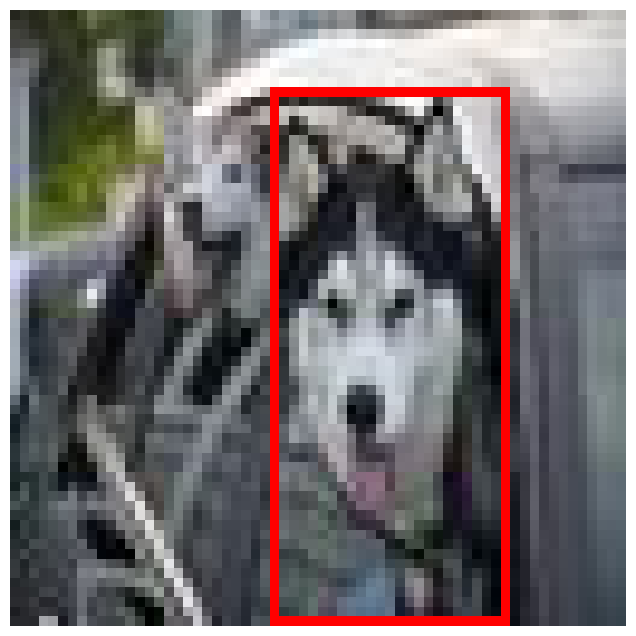

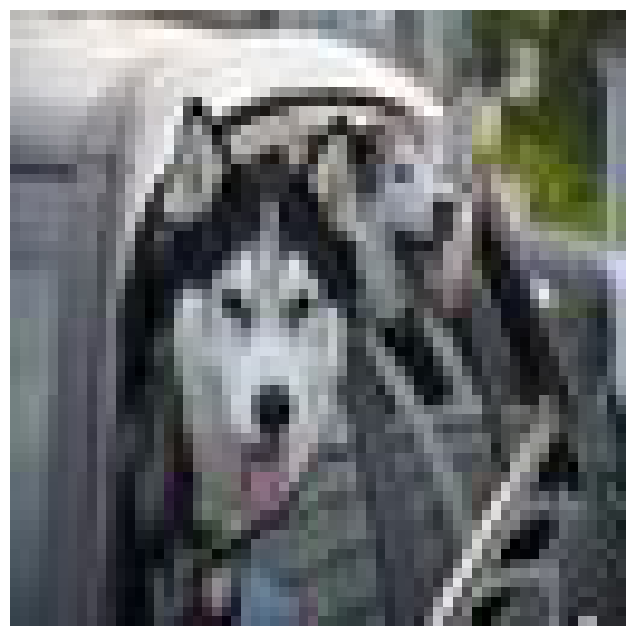

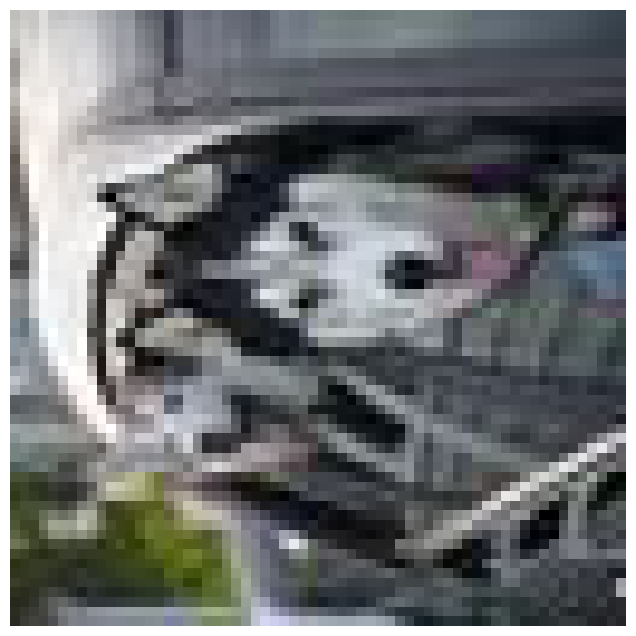

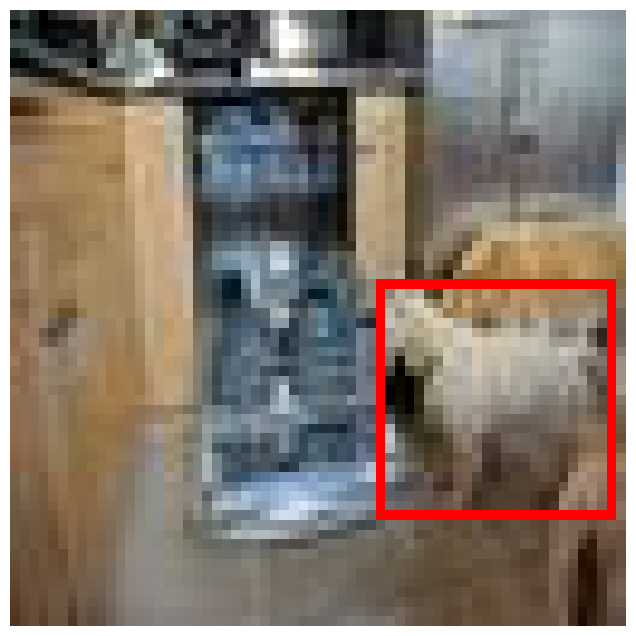

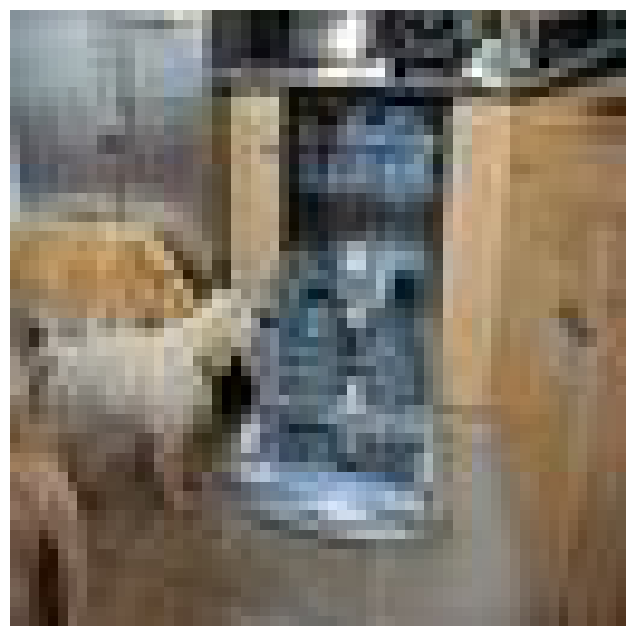

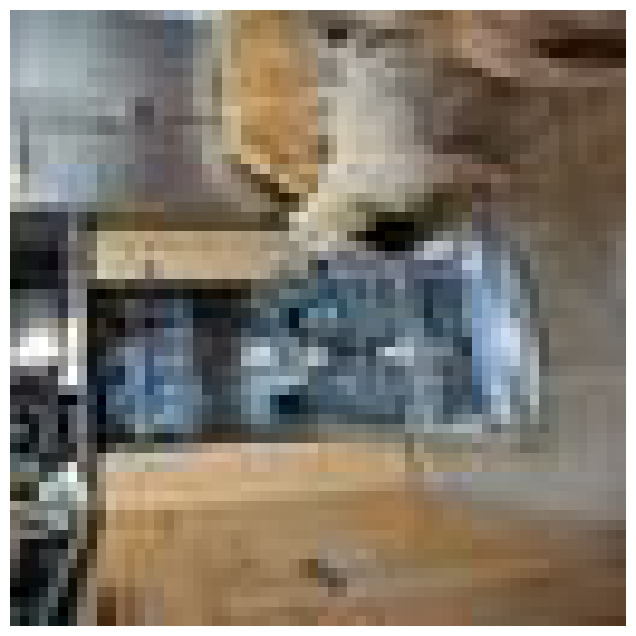

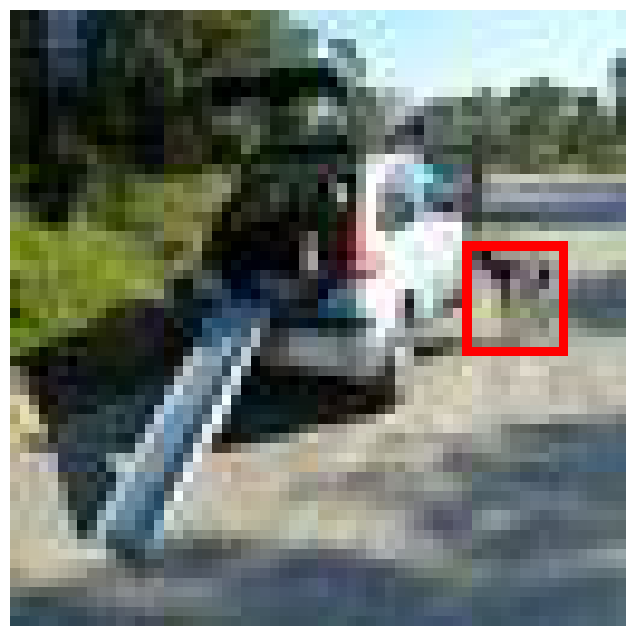

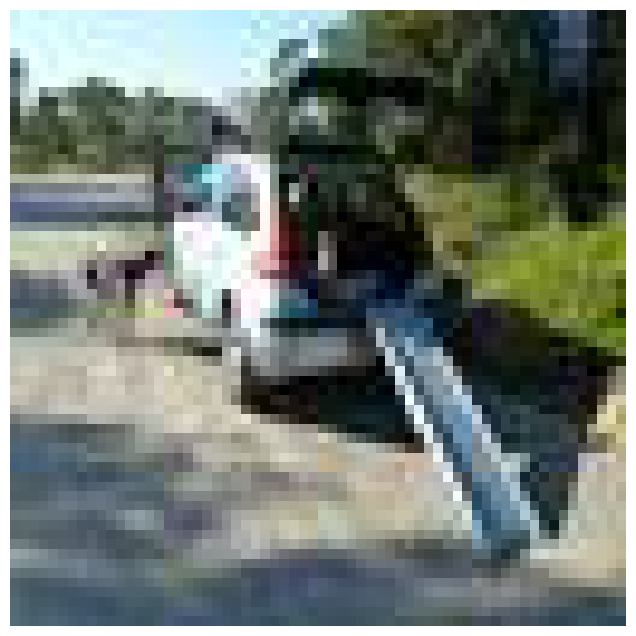

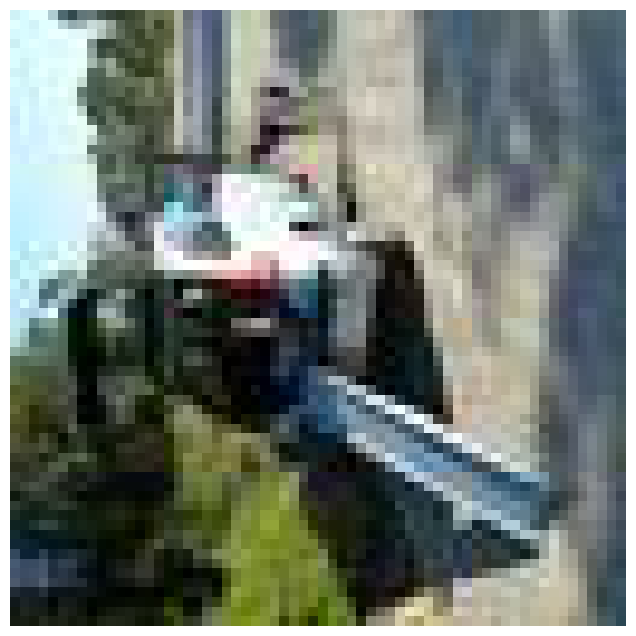

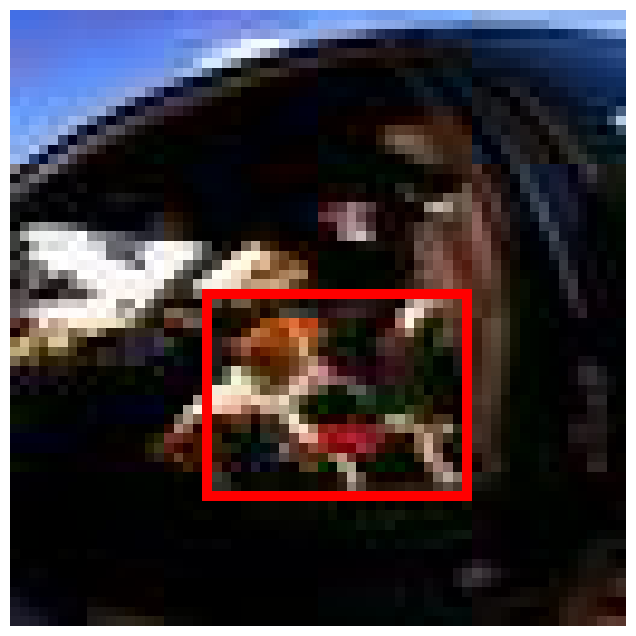

In [13]:
json_path = paths["Preprocessed_Train_json"]
train_path = paths["Train_resized"]

with open(json_path, 'r') as f:
    coco_data = js.load(f)

    i=0

for img in coco_data:
    img_path = path.join(train_path, img["img_id"])
    if not path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    x, y, w, h = img["bbox"]
    cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    i+=1
    if i==100:
        break